# Introduction
We build and evaluate a systematic strategy to forecast NVDA’s overnight (close-to-open) returns using only information available at the prior US market close. The feature set captures market, sector, and peer-company signals, with economically motivated design choices and strict controls against data leakage. Using data from July 2023 to June 2025, we compare regularized linear baselines and non-linear models under a clear train/holdout split. Forecasts are translated into trading positions and evaluated out-of-sample against investable benchmarks, including buy-and-hold NVDA and the SOXX sector ETF.

# Featured Stocks

To motivate the peer universe, we also provide some brief references to recent news highlighting economic links between NVIDIA and several related companies, illustrating why some tickers are included in the feature set.

AMD, AVGO, GOOGL, MSFT, ORCL, TSM:
[How Sam Altman Tied Tech’s Biggest Players to OpenAI](https://www.wsj.com/tech/ai/sam-altman-open-ai-nvidia-deals-d10a6525)

ADBE, NOW, SAP, SNOW:
[Snowflake Teams with NVIDIA to Deliver Full-Stack AI Platform for Customers to Transform Their Industries](https://www.businesswire.com/news/home/20240318504019/en/Snowflake-Teams-with-NVIDIA-to-Deliver-Full-Stack-AI-Platform-for-Customers-to-Transform-Their-Industries)

DELL, HPE, SMCI:
[Dell Technologies Expands Dell AI Factory with NVIDIA to Turbocharge AI Adoption](https://www.dell.com/en-us/dt/corporate/newsroom/announcements/detailpage.press-releases~usa~2024~05~20240520-dell-technologies-expands-dell-ai-factory-with-nvidia-to-turbocharge-ai-adoption.htm#/filter-on/Country:en-us)

INTC:
[Investors Love Intel Again. That Still Doesn’t Solve Its Problems.](https://www.wsj.com/tech/investors-love-intel-again-that-still-doesnt-solve-its-problems-00d2dc0d)

AMZN:
[OpenAI, Amazon Sign $38 Billion Cloud Deal](https://www.wsj.com/tech/ai/openai-amazon-sign-38-billion-cloud-deal-89ff8650)

NOK:
[Nvidia to invest $1bn in Nokia as chip giant extends deal spree](https://on.ft.com/47MfGjm)

We further include a supplementary set of peer tickers chosen for economic relevance; we do not individually justify these selections.

AAPL, AKAM, AMAT, ANET, ASML, CAT, CRM, CSCO, DASTY, HNHPF, ILMN, IQV, JNJ, KLAC, LCID, LI, LLY, LNVGY, LOW, LRCX, MBGYY, META, MU, NIO, PLTR, RXRX, SIEGY, SOUN, STLA, T, TMUS, UBER, XPEV

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from pathlib import Path  # Added for results directory
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from arch import arch_model  # For GARCH
import warnings  # Added to suppress convergence warnings
from itertools import product  # Needed for ENet grid search

# Personal plot configuration
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Config and Globals

In [2]:
START = "2023-07-01"
END = "2025-06-30"

TARGET = "NVDA"

# fmt: off
PEERS = [
    # Cloud / AI infra
    "MSFT","GOOGL","AMZN","ORCL","AKAM","META","AAPL",
    # Telco
    "NOK","TMUS","T",
    # Auto / AV (US-traded lines incl. OTC ADRs)
    "UBER","STLA","LCID","MBGYY","LI","XPEV","NIO",
    # Hardware / systems
    "DELL","HPE","CSCO","SMCI","LNVGY",
    # Healthcare
    "JNJ","LLY","ILMN","IQV",
    # Software / manufacturing / twins adjacents
    "PLTR","LOW","SIEGY","TSM","HNHPF","CAT","DASTY",
    # Enterprise software
    "SNOW","NOW","SAP","ADBE","CRM","ANET",
    # Semis & equipment
    "AVGO","ASML","AMAT","KLAC","LRCX","MU",
    # Competitors
    "AMD","INTC",
    # NVDA direct investments
    "RXRX","SOUN",
]
# fmt: on

CTRL_TICKER = "SOXX"

ALL_TICKERS = sorted(set([TARGET] + PEERS + [CTRL_TICKER]))

# Load Data

In [3]:
# Our data loader.
from src.pipeline.loader import DataLoader

In [4]:
dl = DataLoader(
    tickers=ALL_TICKERS,
    start=START,
    end=END,
)

# Fetch and adjust data
dl.fetch_data().adjust_data()

# MultiIndex ["OHLCV-TR", "Ticker"], with level 0: ["open", "high", "low", "close", "volume", "total_return"]
# All prices and total_return as in Appendix B.
data_cube = dl.get_adjusted_data(source="true")

## Verify Data Load

In [5]:
# Generate needed verification dataframes as suggested in Appendix B.4
return_continuity, event_alignment = dl.verify_data("NVDA")

### Mean Absolute Difference of Returns by Ticker

- Left column: Yahoo with the manual computation using the correct dividend adjustment formula ('True')
- Right column: Yahoo with manual recomputation using Yahoo's approximated dividend adjustment formula ('Manual')."

In [6]:
return_continuity

,MAD Yahoo and True,MAD Yahoo and Manual Recomputation
Ticker,,
AAPL,8.779817e-08,6.317753e-08
ADBE,0.000000e+00,0.000000e+00
AKAM,0.000000e+00,0.000000e+00
AMAT,1.391880e-07,6.402306e-08
AMD,0.000000e+00,0.000000e+00
AMZN,0.000000e+00,0.000000e+00
ANET,0.000000e+00,0.000000e+00
ASML,1.472171e-07,6.447499e-08
AVGO,2.875457e-07,6.482865e-08


### Event Alignment

- Event date (dividend and split if available) including +- 1 day of event.
- Also displays formulas used for computation.
- We explicitly note again that f_split is all 1 because Yahoo data is split adjusted. This is **NOT** a mistake! See method `_fsplit` in `src/pipeline/loader.py` for details.

In [7]:
event_alignment

Ticker                NVDA                                              \
Diagnostics          Event Dividends f_div (True) f_div (Yahoo Approx)   
Date                                                                     
2023-09-05    pre-dividend     0.000     1.000000             1.000000   
2023-09-06     ex-dividend     0.004     0.999918             0.999918   
2023-09-07   post-dividend     0.000     1.000000             1.000000   
2024-06-07       pre-split     0.000     1.000000             1.000000   
2024-06-10           split     0.000     1.000000             1.000000   
2024-06-11      post-split     0.010     0.999918             0.999918   

Ticker                                                               \
Diagnostics Prod_{k > t} g_t (True) Prod_{k > t} g_t (Yahoo Approx)   
Date                                                                  
2023-09-05                 0.999385                        0.999385   
2023-09-06                 0.999467                        0.999467   
2023-09-07                 0.999467                        0.999467   
2024-06-07                 0.999602                        0.999602   
2024-06-10                 0.999602                        0.999602   
2024-06-11                 0.999684                        0.999684   

Ticker                                                                  \
Diagnostics Stock Splits f_split (1; All Yahoo Data is Split Adjusted)   
Date                                                                     
2023-09-05           0.0                                           1.0   
2023-09-06           0.0                                           1.0   
2023-09-07           0.0                                           1.0   
2024-06-07           0.0                                           1.0   
2024-06-10          10.0                                           1.0   
2024-06-11           0.0                                           1.0   

Ticker                                                \
Diagnostics Total Return (True) Total Return (Yahoo)   
Date                                                   
2023-09-05             0.000804             0.000804   
2023-09-06            -0.030550            -0.030550   
2023-09-07            -0.017424            -0.017424   
2024-06-07            -0.000909            -0.000909   
2024-06-10             0.007461             0.007461   
2024-06-11            -0.007144            -0.007144   

Ticker                                   
Diagnostics Total Return (Yahoo Manual)  
Date                                     
2023-09-05                     0.000804  
2023-09-06                    -0.030550  
2023-09-07                    -0.017424  
2024-06-07                    -0.000909  
2024-06-10                     0.007461  
2024-06-11                    -0.007144

# Add Features

In [8]:
# Our methods for feature engineering.
from src.pipeline.preprocess import (
    add_log_return,
    add_close_to_open_return,
    add_realized_annualized_volatility,
    add_momentum,
    add_liquidity,
)

In [9]:
# Note, each ticker has all the features.
# Think of this as a pipeline that is run once.
# Rerunning it will throw exceptions on purpose because the fields already exist.
data_cube = add_log_return(data_cube)  # Field: "log_return"
data_cube = add_close_to_open_return(data_cube)  # Field: "log_ret_co"
data_cube = add_realized_annualized_volatility(data_cube, days=5)  # Field: "vol5"
data_cube = add_momentum(data_cube, days=1)  # Field: "mom1"
data_cube = add_momentum(data_cube, days=5)  # Field: "mom5"
data_cube = add_liquidity(data_cube)  # Field: "log_dvol"

# Build Feature Matrix and Label Vector

In [10]:
# Some helpers that allowed us merge up and downstream code more easily.
from src.merge_helpers import _col, flatten_columns

In [11]:
# Additional globals.
LABEL_COL = "y_nvda_co"
FEATURES = ["log_return", "vol5", "mom1", "mom5", "log_dvol"]

In [12]:
# Label: TARGET (NVDA) close -> open; renaming to work with downstream; copy to avoid aliasing.
y_dirty = (
    data_cube["log_ret_co"][[TARGET]].rename(columns={TARGET: LABEL_COL}, copy=True).rename_axis("Features", axis=1)
)
y = y_dirty.dropna()

X_raw = flatten_columns(data_cube[FEATURES])
# Drop dates (index) in X that were also dropped in y.
X = X_raw.loc[y.index]

X_y = X.join(y)

# Metric and Evaluation Helpers

In [13]:
# Step 3: Configuration for Rolling Window Backtest
FEATURE_COLS = [c for c in X_y.columns if c != LABEL_COL]  # use ALL features

# Train/Validation/Test window length (time-based using pandas DateOffset)
TRAIN_OFFSET = pd.DateOffset(months=12)  # ~1 year
VAL_OFFSET = pd.DateOffset(months=6)  # ~6 months
TEST_OFFSET = pd.DateOffset(months=6)  # ~6 months # Length of the final reporting period
PREDICT_STEP = pd.DateOffset(days=1)  # Predict one day at a time in the test set

# Hyperparameter grid for alpha (Ridge)
ALPHA_GRID = np.logspace(-4, 2, 13)

# Cost config (Account for trading costs for buying and selling, arbitarily set for now)
COST_BPS = 0  # No longer used but keep for compatibility
ONE_WAY = 0.0  # zero cost so PnL is purely signal * y_real

# Step 3.5 - Results registry to store model outputs consistently
RESULTS_DIR = Path("reports")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Each "model_df" is an indexed-by-date DataFrame with at least columns: ["y_hat","y_real","signal","signal_prev","cost","pnl"]
results_store = {}  # dict[str, pd.DataFrame] keyed by model name
results_summary = None  # pd.DataFrame summary table


def register_results(name: str, df: pd.DataFrame):
    """Register a model's walk-forward result; persists to CSV."""
    if df is None or df.empty:
        print(f"[WARN] No results DataFrame provided for {name}. Skipping registration.")
        return
    assert {"y_real", "pnl"}.issubset(df.columns), f"{name} missing required columns 'y_real', 'pnl'"
    results_store[name] = df.copy()
    df_out = df.copy()
    # Save results to CSV file
    try:
        df_out.to_csv(RESULTS_DIR / f"{name}_wf.csv", index=True)
        print(f"[INFO] Results for {name} saved to {RESULTS_DIR / f'{name}_wf.csv'}")
    except Exception as e:
        print(f"[ERROR] Failed to save results for {name} to CSV: {e}")


def ann_stats(returns: pd.Series, periods_per_year=252):
    """Calculates annualized return, volatility, and Sharpe ratio."""
    r = returns.dropna()
    if r.empty:
        return {"ann_ret": np.nan, "ann_vol": np.nan, "sharpe": np.nan}
    mu = r.mean() * periods_per_year
    vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    shp = mu / vol if vol > 1e-9 else (0 if mu == 0 else np.sign(mu) * np.inf)  # Handle zero vol
    return {"ann_ret": mu, "ann_vol": vol, "sharpe": shp}


def summarize_results(results_store: dict) -> pd.DataFrame:
    """Creates a summary table of performance metrics for all registered models."""
    rows = []
    for name, df in results_store.items():
        if df is None or df.empty:
            continue  # Skip if no results

        net = ann_stats(df["pnl"])
        # Ensure y_real exists before calculating BH stats
        bh = (
            ann_stats(df["y_real"])
            if "y_real" in df.columns
            else {"ann_ret": np.nan, "ann_vol": np.nan, "sharpe": np.nan}
        )

        # Calculate turnover and exposure if signal columns exist
        turn = np.nan
        expo = pd.Series(dtype=float)
        if {"signal", "signal_prev"}.issubset(df.columns):
            turn = (df["signal"] - df["signal_prev"].fillna(0)).abs().mean()
            expo = df["signal"].value_counts(normalize=True)

        rows.append(
            {
                "model": name,
                **{f"net_{k}": v for k, v in net.items()},
                **{f"bh_{k}": v for k, v in bh.items()},  # Baseline is buy&hold of the target leg (e.g., C->O or C->C)
                "turnover_legs_per_day": float(turn),
                "pct_long": float(expo.get(1, 0.0)),
                "pct_short": float(expo.get(-1, 0.0)),
                # Calculate pct_flat ensuring it sums to 1 even if signal has NaNs
                "pct_flat": max(0.0, 1.0 - expo.get(1, 0.0) - expo.get(-1, 0.0)),
            }
        )

    if not rows:
        print("[WARN] No results found in results_store to summarize.")
        return pd.DataFrame()

    out = pd.DataFrame(rows).set_index("model").sort_values("net_sharpe", ascending=False)
    # Save summary to CSV
    try:
        out.to_csv(RESULTS_DIR / "model_summary.csv")
        print(f"[INFO] Model summary saved to {RESULTS_DIR / 'model_summary.csv'}")
    except Exception as e:
        print(f"[ERROR] Failed to save model summary to CSV: {e}")
    return out

# Models and Validation

In [14]:
# Merge helper.
from src.merge_helpers import check_df_empty

In [15]:
# Some more globals. These were also introduced to merge the code logic.
CTRL_COL = _col(CTRL_TICKER, "log_return")
LOG_RETURN_COLS = [col for col in X_y.columns if "log_return" in col]
PEERS_ALL = [col for col in LOG_RETURN_COLS if (CTRL_TICKER not in col) or (TARGET not in col)]
USE_PEERS = PEERS_ALL

## Model 1: Ridge Regression

In [16]:
# --- Residualization helpers: calculate_betas() and apply_resid_slice() ---
def calculate_betas(train_df_raw: pd.DataFrame, feature_cols, ctrl_col: str, peers_list=PEERS_ALL):
    """
    Estimate a single slope beta for each peer vs the control factor on the TRAIN set.
    Returns: dict {peer -> beta}.

    Notes:
    - Matches the later code that prints a single number per peer (no intercept stored).
    - Uses de-meaned series to get a stable slope; falls back to 0.0 if insufficient data.
    """
    betas = {}
    if ctrl_col not in train_df_raw.columns:
        raise KeyError(f"Control column '{ctrl_col}' not found in training data.")

    ctrl = train_df_raw[ctrl_col]

    # De-mean control once for numerical stability
    x = (ctrl - ctrl.mean()).to_frame(name=ctrl_col)

    for p in peers_list:
        if p not in feature_cols or p not in train_df_raw.columns:
            continue

        y_raw = train_df_raw[p].astype(float)
        df = pd.concat([x, (y_raw - y_raw.mean()).rename(p)], axis=1).dropna()
        if check_df_empty(df):
            betas[p] = 0.0
            continue

        # Closed-form slope on demeaned data: beta = cov(x,y) / var(x)
        x_dm = df[ctrl_col].values
        y_dm = df[p].values
        denom = (x_dm**2).sum()
        if denom <= 0:
            betas[p] = 0.0
        else:
            betas[p] = float((x_dm * y_dm).sum() / denom)

    return betas


def apply_resid_slice(df_slice: pd.DataFrame, betas: dict, feature_cols, ctrl_col: str, peers_list):
    """
    Apply residualization to an arbitrary slice (TRAIN/VAL/TEST) using precomputed betas.

    Output columns:
      - control column (if present in feature_cols),
      - one column per peer: '<peer>_res' = peer - beta_peer * control
    """
    if ctrl_col not in df_slice.columns:
        raise KeyError(f"Control column '{ctrl_col}' not found in the slice.")

    out_cols = {}
    # Pass through the control factor if requested
    if ctrl_col in feature_cols:
        out_cols[ctrl_col] = df_slice[ctrl_col].astype(float)

    ctrl_vals = df_slice[ctrl_col].astype(float)

    for p in peers_list:
        if p in df_slice.columns:
            b = betas.get(p, 0.0)
            peer_vals = df_slice[p].astype(float)
            out_cols[f"{p}_res"] = peer_vals - b * ctrl_vals  # residualized feature

    if not out_cols:
        # Return an empty DF with expected columns if nothing matched
        cols = [ctrl_col] if ctrl_col in feature_cols else []
        cols += [f"{p}_res" for p in peers_list]
        return pd.DataFrame(index=df_slice.index, columns=cols, dtype=float)

    return pd.DataFrame(out_cols, index=df_slice.index)


# -----------------------------
# Ridge (FixedFWD, Resid) block
# -----------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


def _alpha_grid_fallback():
    # Prefer a Ridge-specific grid if present; otherwise fall back cleanly.
    if "ALPHA_GRID_RIDGE" in globals():
        return globals()["ALPHA_GRID_RIDGE"]
    if "ALPHA_GRID" in globals():
        return globals()["ALPHA_GRID"]
    return np.logspace(-4, 2, 13)  # sane default


def _best_alpha_by_val(X_train_res, y_train, X_val_res, y_val, alphas=None):
    """
    Simple forward validation:
      - Fit a Ridge model for each alpha on TRAIN (residualized features).
      - Pick alpha with the lowest MSE on VALIDATION.
      - Refit a new model on combined (TRAIN + VALIDATION) using that alpha.
    Returns: best_alpha, final_pipeline, common_features_used
    """
    if alphas is None:
        alphas = _alpha_grid_fallback()

    best_alpha, best_mse = None, np.inf

    # Common features between train and val
    common_features = X_train_res.columns.intersection(X_val_res.columns).tolist()
    if not common_features:
        print("[WARN] No common features between residualized train and validation sets.")
        return 1.0, None, []

    # ---- 1) Validation loop to select alpha ----
    train_fit_df = X_train_res[common_features].join(y_train).dropna()
    val_fit_df = X_val_res[common_features].join(y_val).dropna()
    if check_df_empty(train_fit_df) or check_df_empty(val_fit_df):
        print("[ERROR] Empty TRAIN or VAL after NaN drop in _best_alpha_by_val.")
        return 1.0, None, common_features

    Xtr_fit, ytr_fit = train_fit_df[common_features], train_fit_df[y_train.name]
    Xva_fit, yva_fit = val_fit_df[common_features], val_fit_df[y_val.name]

    for a in alphas:
        pipe = Pipeline(
            [
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("ridge", Ridge(alpha=a, fit_intercept=True, random_state=42)),
            ]
        )
        try:
            pipe.fit(Xtr_fit, ytr_fit)  # scaler fit ONLY on train
            y_pred_val = pipe.predict(Xva_fit)  # transform val using train scaler
            mse = mean_squared_error(yva_fit, y_pred_val)
            if mse < best_mse:
                best_mse, best_alpha = mse, a
        except Exception as e:
            print(f"[WARN] Ridge fit failed for alpha={a}: {e}")

    if best_alpha is None:
        print("[WARN] No best alpha found. Defaulting to 1.0")
        best_alpha = 1.0

    # ---- 2) Refit on (Train + Val) ----
    X_tv_res = pd.concat([X_train_res, X_val_res], axis=0)[common_features]
    y_tv = pd.concat([y_train, y_val], axis=0)

    final_pipe = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("ridge", Ridge(alpha=best_alpha, fit_intercept=True, random_state=42)),
        ]
    )

    final_fit_df = X_tv_res.join(y_tv).dropna()
    if check_df_empty(final_fit_df):
        print("[ERROR] Combined Train+Val residualized data empty. Cannot fit final model.")
        return best_alpha, None, common_features

    try:
        final_pipe.fit(final_fit_df[common_features], final_fit_df[y_tv.name])
    except Exception as e:
        print(f"[ERROR] Final Ridge fit failed with alpha={best_alpha}: {e}")
        return best_alpha, None, common_features

    return best_alpha, final_pipe, common_features


def ridge_fixedfwd_resid_eval(
    X_y: pd.DataFrame,
    feature_cols=FEATURE_COLS,  # raw feature cols in X_y
    label_col=LABEL_COL,
    ctrl_col=CTRL_COL,
    peers_list=USE_PEERS,  # peers for residualization
    train_offset=TRAIN_OFFSET,
    val_offset=VAL_OFFSET,
    test_offset=TEST_OFFSET,
    cost_one_way=ONE_WAY,
    alphas=None,
):
    """
    Fixed Forward Validation (aligns with other models):
      - Use one fixed Train / Val / Test split.
      - Residualize once using betas from TRAIN.
      - Tune alpha on Train→Val, refit on Train+Val, evaluate on Test.
      - Returns a DataFrame indexed by test dates with columns:
            ['y_hat','y_real','alpha','signal','signal_prev','cost','pnl']
    """
    # ---- 0) Build fixed splits (same logic as others) ----
    dates = X_y.index
    first_train_start = dates.min()
    train_end_date = first_train_start + train_offset - pd.Timedelta(days=1)
    val_end_date = train_end_date + val_offset
    test_end_date = val_end_date + test_offset

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

    print(
        f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()}   to {val_df_raw.index.max().date()}   ({len(val_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()}  to {test_df_raw.index.max().date()}  ({len(test_df_raw)} days)"
    )

    if check_df_empty(train_df_raw) or check_df_empty(val_df_raw) or check_df_empty(test_df_raw):
        raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")

    # ---- 1) Residualization betas from TRAIN and apply to all splits ----
    print("[INFO] Calculating residualization betas on fixed training set (Ridge)...")
    betas_fixed_ridge = calculate_betas(train_df_raw, feature_cols, ctrl_col, peers_list)

    print("[INFO] Applying residualization to Train/Val/Test (Ridge)...")
    X_train_res = apply_resid_slice(train_df_raw, betas_fixed_ridge, feature_cols, ctrl_col, peers_list)
    X_val_res = apply_resid_slice(val_df_raw, betas_fixed_ridge, feature_cols, ctrl_col, peers_list)
    X_test_res = apply_resid_slice(test_df_raw, betas_fixed_ridge, feature_cols, ctrl_col, peers_list)

    # Final residualized feature names (ctrl + peers_res) to keep consistent ordering
    resid_feature_cols = []
    if ctrl_col in feature_cols:
        resid_feature_cols.append(ctrl_col)
    resid_feature_cols += [p + "_res" for p in peers_list]

    # bring in style features if present
    style_candidates = ["nvda_vol5", "nvda_mom1", "nvda_mom5", "nvda_log_dvol"]
    style_cols = [c for c in style_candidates if c in feature_cols and c in train_df_raw.columns]

    # build FULL design matrices = [residualized peers (+ctrl)] ⨁ [style features]
    X_train_full = pd.concat([X_train_res[resid_feature_cols], train_df_raw[style_cols]], axis=1)
    X_val_full = pd.concat([X_val_res[resid_feature_cols], val_df_raw[style_cols]], axis=1)
    X_test_full = pd.concat([X_test_res[resid_feature_cols], test_df_raw[style_cols]], axis=1)

    # Targets
    y_train = train_df_raw[label_col]
    y_val = val_df_raw[label_col]
    y_test = test_df_raw[label_col]

    # ---- 2) Tune alpha on Train→Val, then refit on Train+Val ----
    best_alpha, final_model, common_features = _best_alpha_by_val(
        X_train_full, y_train, X_val_full, y_val, alphas=alphas
    )
    if final_model is None:
        print("[ERROR] Final Ridge model could not be trained. Returning empty results.")
        return pd.DataFrame(columns=["y_hat", "y_real", "alpha", "signal", "signal_prev", "cost", "pnl"])

    print(f"[INFO] Best Ridge alpha (FixedFWD): {best_alpha:.6f}")

    # Determine the exact feature order the model expects
    try:
        model_features = list(final_model.feature_names_in_)  # sklearn >= 1.0
    except AttributeError:
        model_features = list(common_features)  # fallback

    # ---- 3) Predict on TEST and compute PnL ----
    X_test_predict = X_test_full.reindex(columns=model_features)
    test_pred_df = X_test_predict.join(y_test.rename("y_real")).dropna()
    if check_df_empty(test_pred_df):
        print("[WARN] No valid rows in TEST after NaN drop. Returning empty results.")
        return pd.DataFrame(columns=["y_hat", "y_real", "alpha", "signal", "signal_prev", "cost", "pnl"])

    # Predictions
    y_hat_test = pd.Series(final_model.predict(test_pred_df[model_features]), index=test_pred_df.index, name="y_hat")

    out = test_pred_df[["y_real"]].copy()
    out["y_hat"] = y_hat_test
    out["alpha"] = best_alpha
    out["signal"] = np.where(out["y_hat"] > 0, 1, np.where(out["y_hat"] < 0, -1, 0))
    out["signal_prev"] = out["signal"].shift(1).fillna(0)
    legs = (out["signal_prev"] - out["signal_prev"].shift(1).fillna(0)).abs()
    out["cost"] = legs * cost_one_way
    out["pnl"] = out["signal_prev"] * out["y_real"] - out["cost"]

    out = out[["y_hat", "y_real", "alpha", "signal", "signal_prev", "cost", "pnl"]]
    out.index.name = "date"
    return out


# Execute the FixedFWD evaluation for Ridge and register with unified key
print("\n" + "=" * 50)
print("Executing Ridge (FixedFWD, Residualized Features)")
print("=" * 50)
ridge_fixedfwd_resid_df = ridge_fixedfwd_resid_eval(X_y)
print("\n[INFO] Ridge_FixedFWD_Resid (head of results):")
if not check_df_empty(ridge_fixedfwd_resid_df):
    print(ridge_fixedfwd_resid_df.head())
else:
    print("[INFO] No results generated.")
print("=" * 50)

# Register the results with the same naming convention as other models
register_results("Ridge_FixedFWD_Resid", ridge_fixedfwd_resid_df)


Executing Ridge (FixedFWD, Residualized Features)
[INFO] Fixed Splits | Train: 2023-07-05 to 2024-07-03 (252 days)
[INFO] Fixed Splits | Val  : 2024-07-05   to 2025-01-03   (127 days)
[INFO] Fixed Splits | Test : 2025-01-06  to 2025-06-26  (118 days)
[INFO] Calculating residualization betas on fixed training set (Ridge)...
[INFO] Applying residualization to Train/Val/Test (Ridge)...
[INFO] Best Ridge alpha (FixedFWD): 100.000000

[INFO] Ridge_FixedFWD_Resid (head of results):
               y_hat    y_real  alpha  signal  signal_prev  cost       pnl
date                                                                      
2025-01-06  0.007870  0.023806  100.0       1          0.0   0.0  0.000000
2025-01-07  0.003779  0.017261  100.0       1          1.0   0.0  0.017261
2025-01-08 -0.000202 -0.019168  100.0      -1          1.0   0.0 -0.019168
2025-01-10  0.002344 -0.044535  100.0       1         -1.0   0.0  0.044535
2025-01-13 -0.008336  0.020946  100.0      -1          1.0   0.0  0.


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                      net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                    
Ridge_FixedFWD_Resid       0.4397       0.4189      1.0496     -0.1006   

                      bh_ann_vol  bh_sharpe  turnover_legs_per_day  pct_long  \
model                                                                          
Ridge_FixedFWD_Resid      0.4212    -0.2389                 0.7881    0.7373   

                      pct_short  pct_flat  
model                                      
Ridge_FixedFWD_Resid     0.2627    0.0000  


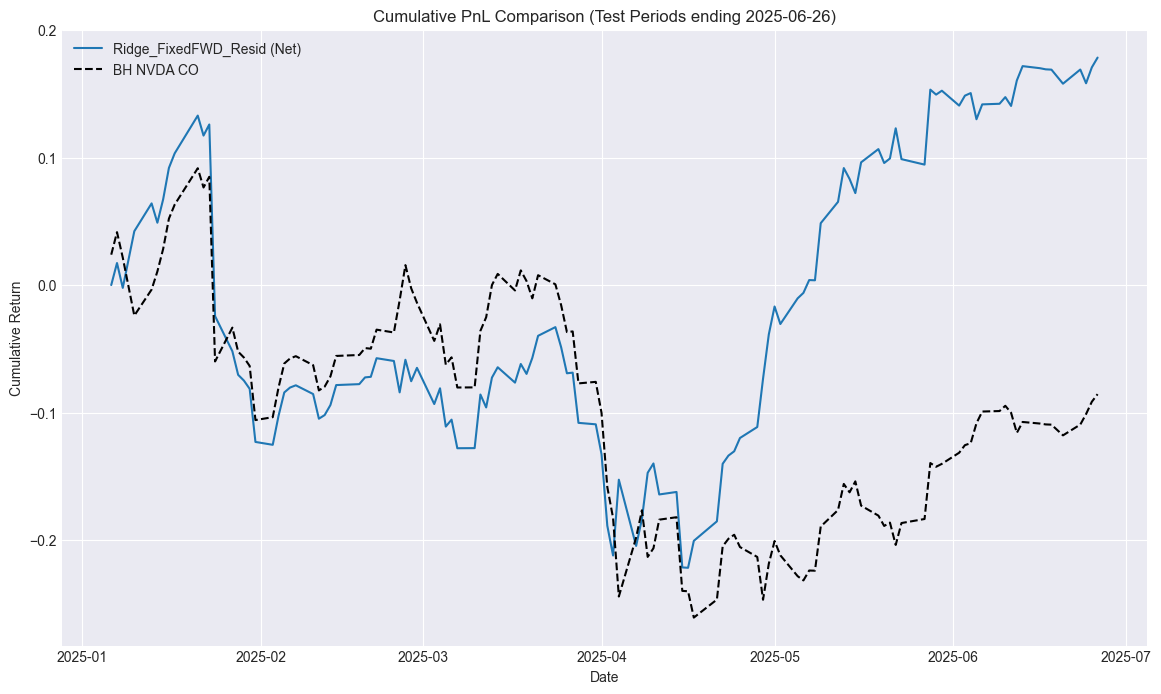

[INFO] Ridge_FixedFWD_Resid best alpha (FixedFWD): 100


In [17]:
# Step 6: Evaluation (Using the results registry functions), and plotting results

# Summarize results from the store
print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- Plotting Results ---
if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0

    # Plot strategy cumulative returns
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1

            if not df["cum_pnl"].isna().all():
                plt.plot(df.index, df["cum_pnl"], label=f"{name} (Net)")
                plot_count += 1
            else:
                print(f"[INFO] Skipping plot for {name} - cumulative PnL is all NaN.")

    # Add Buy & Hold NVDA Close-to-Open benchmark from a representative run
    bh_df_source = None
    bh_col_name = "cum_bh"
    for name, df in results_store.items():
        if df is not None and not df.empty and "y_real" in df.columns:
            bh_df_source = df.copy()
            bh_df_source[bh_col_name] = (1 + bh_df_source["y_real"].fillna(0)).cumprod() - 1
            break

    if bh_df_source is not None and not bh_df_source[bh_col_name].isna().all():
        plt.plot(bh_df_source.index, bh_df_source[bh_col_name], label="BH NVDA CO", linestyle="--", color="black")
        plot_count += 1
    else:
        print("[WARN] Could not plot Buy & Hold NVDA (CO) benchmark.")

    if plot_count > 0:
        all_min_dates = [df.index.min() for df in results_store.values() if df is not None and not df.empty]
        all_max_dates = [df.index.max() for df in results_store.values() if df is not None and not df.empty]

        if all_min_dates and all_max_dates:
            max_date_str = max(all_max_dates).date()
            plt.title(f"Cumulative PnL Comparison (Test Periods ending {max_date_str})")
        else:
            plt.title("Cumulative PnL Comparison")

        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("[INFO] No valid model results found to plot.")

    # Ridge alpha (FixedFWD): constant over test; show as text if present
    if "Ridge_FixedFWD_Resid" in results_store:
        ridge_df = results_store["Ridge_FixedFWD_Resid"]
        if "alpha" in ridge_df.columns and not ridge_df["alpha"].dropna().empty:
            alpha_val = ridge_df["alpha"].dropna().iloc[0]
            print(f"[INFO] Ridge_FixedFWD_Resid best alpha (FixedFWD): {alpha_val:.6g}")
        else:
            print("[INFO] Alpha column not available or empty for Ridge model.")

else:
    print("[INFO] results_store is empty. Nothing to plot.")

In evaluating the performance of our daily trading strategies, we utilize specific Buy-and-Hold (BH) benchmarks designed to directly correspond to the strategies' intended holding periods, rather than a simple long-term investment "buy and hold forever" approach. This decision allows for a fairer assessment of the timing value added by the models, instead of comparing it to some investment.

The benchmarks used are: BH NVDA CO (Close-to-Open), which represents the return achieved by passively buying NVDA stock at the market close each day and selling it at the market open the following day, aligning with strategies targeting overnight movements, and BH NVDA CC (Close-to-Close), representing the standard daily return from holding NVDA from one day's close to the next, used for comparing strategies that target full-day returns. By comparing our strategies against these interval-specific benchmarks, we can better isolate whether our models' signals generated alpha beyond simply holding the asset during the targeted trading windows.

### Model 2: Lasso Models

In [18]:
# Hyperparameter grids
ALPHA_GRID_RIDGE = np.logspace(-4, 2, 13)  # Alpha for Ridge
ALPHA_GRID_LASSO = np.logspace(-5, -1, 13)  # Alpha for Lasso (typically needs smaller values)
ALPHA_GRID_ENET = np.logspace(-5, -1, 13)  # Alpha for ElasticNet
L1_RATIO_GRID_ENET = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]  # L1 ratio for ElasticNet

In [19]:
# Suppress convergence warnings from Lasso during grid search
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# === Lasso Backtest with Fixed Forward Validation ===
print("\n" + "=" * 50)
print("Executing Lasso Backtest with Fixed Forward Validation")
print("=" * 50)

# Required variables: X_y, FEATURE_COLS, LABEL_COL, CTRL_COL, use_peers, TRAIN_OFFSET, VAL_OFFSET, TEST_OFFSET, ALPHA_GRID_LASSO, COST_BPS, ONE_WAY,register_results function

# imports used below (safe to re-import)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# --- 1. Define Fixed Time Splits ---
dates = X_y.index
first_train_start = dates.min()
train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
val_end_date = train_end_date + VAL_OFFSET
test_end_date = val_end_date + TEST_OFFSET  # Or use dates.max() if preferred

train_df_raw = X_y.loc[first_train_start:train_end_date]
val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]  # Use test_end_date

print(
    f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
)
print(
    f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()} to {val_df_raw.index.max().date()} ({len(val_df_raw)} days)"
)
print(
    f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()} to {test_df_raw.index.max().date()} ({len(test_df_raw)} days)"
)

if check_df_empty(train_df_raw) or check_df_empty(val_df_raw) or check_df_empty(test_df_raw):
    raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")


# --- 2. Calculate Betas ONCE on Training Data ---
def calculate_betas(train_data_raw, feature_list, ctrl_col_name, peers_list):
    """Calculates residualization betas based on the raw training data."""
    betas = {}
    if ctrl_col_name in train_data_raw.columns:
        train_features_raw = train_data_raw[feature_list]  # Use only feature columns for beta calc
        for p in peers_list:
            if p in train_features_raw.columns:
                df_tr = train_features_raw[[p, ctrl_col_name]].dropna()
                if not check_df_empty(df_tr) and df_tr[ctrl_col_name].std().mean() > 1e-8:
                    try:
                        lr = LinearRegression().fit(df_tr[[ctrl_col_name]], df_tr[p])  # TODO
                        betas[p] = float(np.ravel(lr.coef_)[0])
                    except Exception as e:
                        print(f"[WARN] Beta calc failed for {p}: {e}")
                        betas[p] = np.nan
                else:
                    betas[p] = np.nan
            else:
                betas[p] = np.nan  # Peer not in training data
    else:
        print(f"[WARN] Control column '{ctrl_col_name}' not in training data.")
    return betas


print("[INFO] Calculating residualization betas on fixed training set...")
betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, USE_PEERS)
print(f"[INFO] Betas calculated: { {k: f'{v:.4f}' for k, v in betas_fixed.items()} }")  # Print formatted betas


# --- 3. Apply Residualization to All Fixed Sets ---
def apply_resid_slice(df_raw_slice, betas_dict, feature_list, ctrl_col_name, peers_list):
    """Applies pre-calculated betas to residualize features in a data slice."""
    df_res = pd.DataFrame(index=df_raw_slice.index)
    df_features_raw = df_raw_slice[feature_list]  # Work with feature columns only

    if ctrl_col_name in df_features_raw.columns:
        df_res[ctrl_col_name] = df_features_raw[ctrl_col_name]
        soxx_series = df_features_raw[ctrl_col_name]
    else:
        soxx_series = pd.Series(0.0, index=df_features_raw.index)
        print(f"[WARN] Control '{ctrl_col_name}' missing during apply_resid_slice.")

    for p in peers_list:
        beta_p = betas_dict.get(p, np.nan)
        if p in df_features_raw.columns and not np.isnan(beta_p):
            df_res[p + "_res"] = df_features_raw[p] - beta_p * soxx_series
        else:
            df_res[p + "_res"] = np.nan
    return df_res


print("[INFO] Applying residualization to Train, Val, Test sets...")
X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_test_res = apply_resid_slice(test_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)

# Define final feature columns based on residualization
final_feature_cols = []
if CTRL_COL in FEATURE_COLS:
    final_feature_cols.append(CTRL_COL)
final_feature_cols += [p + "_res" for p in USE_PEERS]
print(f"[INFO] Using residualized features: {final_feature_cols}")

# add style features (NVDA vol/mom/liquidity) into the design matrices
style_candidates = [_col(TARGET, feat) for feat in FEATURES]
style_cols = [c for c in style_candidates if c in FEATURE_COLS]

X_train_full = pd.concat([X_train_res[final_feature_cols], train_df_raw[style_cols]], axis=1)
X_val_full = pd.concat([X_val_res[final_feature_cols], val_df_raw[style_cols]], axis=1)
X_test_full = pd.concat([X_test_res[final_feature_cols], test_df_raw[style_cols]], axis=1)

# Align target variables
y_train = train_df_raw[LABEL_COL]
y_val = val_df_raw[LABEL_COL]
y_test = test_df_raw[LABEL_COL]


# --- 4. Tune Alpha using Fixed Train/Val sets with residualized features, then refit with combined train + validation set---
def _best_alpha_by_val_lasso_fixed(X_train_full, y_train, X_val_full, y_val, alphas=ALPHA_GRID_LASSO):
    best_alpha, best_mse = None, np.inf
    common_features = X_train_full.columns.intersection(X_val_full.columns).tolist()
    if not common_features:
        return 1e-3, None  # Default alpha, no model

    # Prepare training data (drop NaNs from features/target alignment)
    # We first drop all columns that are entirely NaN, then drop rows that contain NaN values.
    train_fit_df = (
        X_train_full[common_features].join(y_train.to_frame()).dropna(axis=1, how="all").dropna(axis=0, how="any")
    )
    # Have to update common features because some might have been dropped due to all NaNs
    common_features = [feat for feat in common_features if feat in train_fit_df.columns]
    if check_df_empty(train_fit_df):
        print("[ERROR] Lasso Tuning: Training data empty after NaN drop.")
        return 1e-3, None
    Xtr_fit = train_fit_df[common_features]
    ytr_fit = train_fit_df[LABEL_COL]

    # Prepare validation data similarly
    val_pred_df = X_val_full[common_features].join(y_val).dropna()
    if check_df_empty(val_pred_df):
        print("[WARN] Lasso Tuning: Validation data empty after NaN drop.")  # Continue; result might be less reliable
        Xva_pred = pd.DataFrame(columns=common_features, index=[])
        yva_eval = pd.Series(name=LABEL_COL, dtype=float)
    else:
        Xva_pred = val_pred_df[common_features]
        yva_eval = val_pred_df[LABEL_COL]

    for a in alphas:
        pipe = Pipeline(
            [
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("lasso", Lasso(alpha=a, random_state=42, max_iter=2000)),
            ]
        )
        try:
            pipe.fit(Xtr_fit, ytr_fit)
            if not check_df_empty(Xva_pred):  # Only calculate MSE if validation data exists
                y_pred_val = pipe.predict(Xva_pred)
                mse = mean_squared_error(yva_eval, y_pred_val)
                if mse < best_mse:
                    best_mse, best_alpha = mse, a
            else:
                best_alpha = a
        except ValueError as e:
            print(f"[WARN] Lasso pipe fitting failed for alpha {a}: {e}")
            continue

    if best_alpha is None:
        best_alpha = 1e-3
        print("[WARN] No best alpha found for Lasso. Defaulting.")

    # Refit on combined Train + Val
    X_tv_full = pd.concat([X_train_full, X_val_full], axis=0)[common_features]
    y_tv = pd.concat([y_train, y_val], axis=0)
    final_pipe = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("lasso", Lasso(alpha=best_alpha, random_state=42, max_iter=2000)),
        ]
    )
    final_fit_df = X_tv_full.join(y_tv).dropna()
    if check_df_empty(final_fit_df):
        print("[ERROR] Lasso final fit data empty.")
        return best_alpha, None
    try:
        final_pipe.fit(final_fit_df[common_features], final_fit_df[LABEL_COL])
    except ValueError as e:
        print(f"[ERROR] Lasso final pipe fitting failed: {e}")
        return best_alpha, None
    return best_alpha, final_pipe


print("\n[INFO] Tuning Lasso alpha using fixed validation set...")
best_alpha_lasso, final_model_lasso = _best_alpha_by_val_lasso_fixed(X_train_full, y_train, X_val_full, y_val)

if final_model_lasso is None:
    print("[ERROR] Final Lasso model could not be trained. Skipping testing.")
    wf_lasso_fixed_res = pd.DataFrame()  # Create empty DF
else:
    print(f"[INFO] Best Lasso Alpha: {best_alpha_lasso:.5f}")
    # --- 5. Test Final Model ---
    print("[INFO] Evaluating final Lasso model on fixed test set...")
    # Use the exact features the model expects (Pipeline exposes feature_names_in_ in recent sklearn)
    try:
        model_features = list(final_model_lasso.feature_names_in_)  # Pipeline attribute in newer sklearn
    except AttributeError:
        model_features = X_train_full.columns.tolist()  # Fallback
    X_test_pred = X_test_full[
        model_features
    ].dropna()  # Use features model was trained on, drop rows with NaNs in features
    test_records = []
    prev_sig = 0  # Initialize prev_sig for the fixed test period

    if check_df_empty(X_test_pred):
        print("[WARN] No valid data points in the test set after dropping NaNs.")
        wf_lasso_fixed_res = pd.DataFrame()
    else:
        # Predict on the valid test features
        y_hat_test_array = final_model_lasso.predict(X_test_pred)
        y_hat_test = pd.Series(y_hat_test_array, index=X_test_pred.index)

        # Align predictions with actuals and calculate PnL
        test_results_df = (
            pd.DataFrame({"y_hat": y_hat_test}).join(y_test.rename("y_real")).dropna()
        )  # Ensure alignment and drop rows where y_real might be missing

        if check_df_empty(test_results_df):
            print("[WARN] No common dates between test predictions and actuals.")
            wf_lasso_fixed_res = pd.DataFrame()
        else:
            test_results_df["signal"] = np.where(
                test_results_df["y_hat"] > 0, 1, np.where(test_results_df["y_hat"] < 0, -1, 0)
            )
            # Calculate signal_prev correctly for the fixed test block
            test_results_df["signal_prev"] = (
                test_results_df["signal"].shift(1).fillna(0)
            )  # Start flat on day 1 of test
            test_results_df["delta_pos"] = (test_results_df["signal"] - test_results_df["signal_prev"]).abs()
            test_results_df["cost"] = test_results_df["delta_pos"] * ONE_WAY
            test_results_df["pnl"] = test_results_df["signal"] * test_results_df["y_real"] - test_results_df["cost"]
            # Add hyperparam column for consistency with generic output (though it's fixed here)
            test_results_df["hyperparam"] = best_alpha_lasso
            wf_lasso_fixed_res = test_results_df.copy()

# --- 6. Register Results ---
register_results("Lasso_FixedFWD_Resid", wf_lasso_fixed_res)

# Print head of results
if not check_df_empty(wf_lasso_fixed_res):
    print("\n[INFO] wf_lasso_fixed_res (head of test results):")
    print(wf_lasso_fixed_res.head())
else:
    print("[INFO] No results generated for Lasso Fixed FWD.")
print("=" * 50)


Executing Lasso Backtest with Fixed Forward Validation
[INFO] Fixed Splits | Train: 2023-07-05 to 2024-07-03 (252 days)
[INFO] Fixed Splits | Val  : 2024-07-05 to 2025-01-03 (127 days)
[INFO] Fixed Splits | Test : 2025-01-06 to 2025-06-26 (118 days)
[INFO] Calculating residualization betas on fixed training set...
[INFO] Betas calculated: {'AAPL_log_return': '0.3189', 'ADBE_log_return': '0.4908', 'AKAM_log_return': '0.2000', 'AMAT_log_return': '1.0191', 'AMD_log_return': '1.2410', 'AMZN_log_return': '0.4799', 'ANET_log_return': '0.7815', 'ASML_log_return': '1.0053', 'AVGO_log_return': '1.0666', 'CAT_log_return': '0.3520', 'CRM_log_return': '0.4423', 'CSCO_log_return': '0.1530', 'DASTY_log_return': '0.3145', 'DELL_log_return': '0.7756', 'GOOGL_log_return': '0.3800', 'HNHPF_log_return': '0.2620', 'HPE_log_return': '0.5130', 'ILMN_log_return': '0.3751', 'INTC_log_return': '0.7614', 'IQV_log_return': '0.3665', 'JNJ_log_return': '-0.0893', 'KLAC_log_return': '1.0611', 'LCID_log_return': '0


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                      net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                    
Ridge_FixedFWD_Resid       0.4397       0.4189      1.0496     -0.1006   
Lasso_FixedFWD_Resid       0.2511       0.4210      0.5965     -0.1006   

                      bh_ann_vol  bh_sharpe  turnover_legs_per_day  pct_long  \
model                                                                          
Ridge_FixedFWD_Resid      0.4212    -0.2389                 0.7881    0.7373   
Lasso_FixedFWD_Resid      0.4212    -0.2389                 0.2119    0.9492   

                      pct_short  pct_flat  
model                                      
Ridge_FixedFWD_Resid     0.2627    0.0000  
Lasso_FixedFWD_Resid     0.0508    0.0000  
[INFO] Cumulative PnL plot saved to reports/cumulative_pnl_comparison_lasso.png


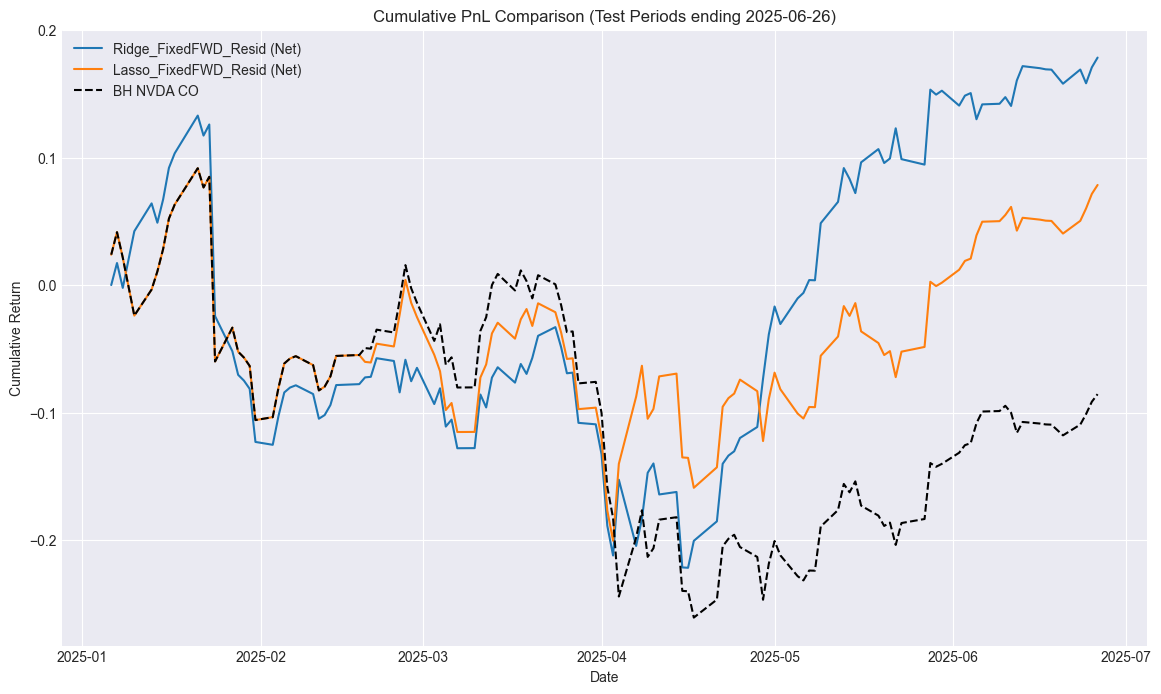

[INFO] Lasso hyperparameter plot saved to reports/Lasso_FixedFWD_Resid_hyperparam_test_period.png


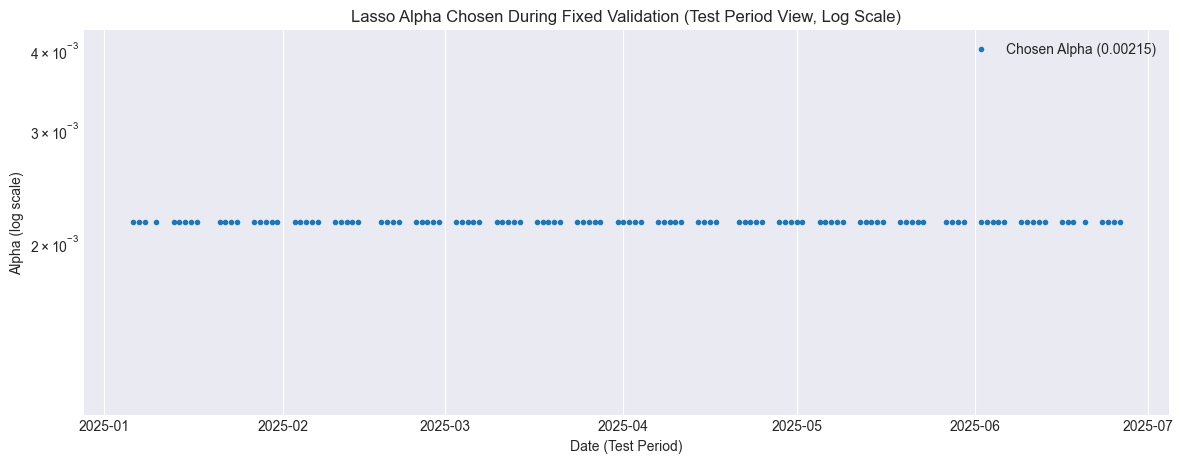

In [20]:
# Step 6: Evaluation (Using the results registry functions), and plotting results

# Summarize results from the store
print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
# Assuming summarize_results function is defined in a previous cell
# It should already handle saving the summary to CSV.
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    # Display more precision in the summary table
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- Plotting Results ---
# Plot only models present in the results_store
if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0

    # Plot strategy cumulative returns
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            # Add cumulative PnL column if needed
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1

            # Ensure data is available for plotting
            if not df["cum_pnl"].isna().all():
                plt.plot(df.index, df["cum_pnl"], label=f"{name} (Net)")
                plot_count += 1
            else:
                print(f"[INFO] Skipping plot for {name} - cumulative PnL is all NaN.")

    # Add Buy & Hold NVDA Close-to-Open benchmark from a representative run
    bh_df_source = None
    bh_col_name = "cum_bh"
    # Find a valid results df to source the benchmark y_real
    for name, df in results_store.items():
        if df is not None and not df.empty and "y_real" in df.columns:
            bh_df_source = df.copy()  # Use this df's index and y_real
            bh_df_source[bh_col_name] = (1 + bh_df_source["y_real"].fillna(0)).cumprod() - 1
            break  # Use the first valid one

    if bh_df_source is not None and not bh_df_source[bh_col_name].isna().all():
        plt.plot(bh_df_source.index, bh_df_source[bh_col_name], label="BH NVDA CO", linestyle="--", color="black")
        plot_count += 1
    else:
        print("[WARN] Could not plot Buy & Hold NVDA (CO) benchmark.")

    if plot_count > 0:
        # Determine overall date range for title
        all_min_dates = [df.index.min() for df in results_store.values() if df is not None and not df.empty]
        all_max_dates = [df.index.max() for df in results_store.values() if df is not None and not df.empty]

        if all_min_dates and all_max_dates:
            min_date_str = min(all_min_dates).date()
            max_date_str = max(all_max_dates).date()
            plt.title(f"Cumulative PnL Comparison (Test Periods ending {max_date_str})")
        else:
            plt.title("Cumulative PnL Comparison")

        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        # Save the plot
        try:
            plt.savefig(RESULTS_DIR / "cumulative_pnl_comparison_lasso.png")  # Changed filename slightly
            print(f"[INFO] Cumulative PnL plot saved to {RESULTS_DIR / 'cumulative_pnl_comparison_lasso.png'}")
        except Exception as e:
            print(f"[ERROR] Failed to save cumulative PnL plot: {e}")
        plt.show()  # Display the plot
    else:
        print("[INFO] No valid model results found to plot.")

    # --- Plot alpha chosen over time for the LASSO model run (Fixed FWD) ---
    lasso_model_key = "Lasso_FixedFWD_Resid"  # Key used in register_results
    if lasso_model_key in results_store:
        lasso_df = results_store[lasso_model_key]
        # Note: For fixed validation, 'hyperparam' column will have the SAME best alpha for all test rows.
        # Plotting it still confirms the alpha chosen.
        if "hyperparam" in lasso_df.columns and not lasso_df["hyperparam"].isna().all():
            plt.figure(figsize=(14, 5))
            # Use scatter plot as value is constant for fixed validation test period
            plt.scatter(
                lasso_df.index,
                lasso_df["hyperparam"],
                marker=".",
                label=f'Chosen Alpha ({lasso_df["hyperparam"].iloc[0]:.5f})',
            )
            plt.yscale("log")  # Use log scale for alpha
            plt.title(f"Lasso Alpha Chosen During Fixed Validation (Test Period View, Log Scale)")
            plt.xlabel("Date (Test Period)")
            plt.ylabel("Alpha (log scale)")
            # Set y-limits to better view the constant alpha if needed, adjust padding
            min_alpha = lasso_df["hyperparam"].min()
            max_alpha = lasso_df["hyperparam"].max()
            if min_alpha == max_alpha and min_alpha > 0:
                plt.ylim(min_alpha * 0.5, max_alpha * 2)  # Example padding for log scale
            plt.legend()
            plt.grid(True)
            # Save the plot
            try:
                plot_filename = f"{lasso_model_key}_hyperparam_test_period.png"
                plt.savefig(RESULTS_DIR / plot_filename)
                print(f"[INFO] Lasso hyperparameter plot saved to {RESULTS_DIR / plot_filename}")
            except Exception as e:
                print(f"[ERROR] Failed to save hyperparameter plot for {lasso_model_key}: {e}")
            plt.show()  # Display the plot
        else:
            print(f"[INFO] Hyperparameter column ('hyperparam') not available or empty for {lasso_model_key}.")
    else:
        print(f"[INFO] Results for {lasso_model_key} not found in results_store.")

else:
    print("[INFO] results_store is empty. Nothing to plot.")

### Model 3: Elastic Net

In [21]:
# --- Ensure Config Variables Exist (Assume defined in previous cells) ---
# Required: X_y, FEATURE_COLS, LABEL_COL, CTRL_COL, use_peers, TRAIN_OFFSET, VAL_OFFSET, TEST_OFFSET, ALPHA_GRID_ENET, L1_RATIO_GRID_ENET, COST_BPS, ONE_WAY,
#           calculate_betas, apply_resid_slice, register_results functions

# --- 1. Check if splits exist from a previous block (e.g., Lasso block), otherwise create ---
if "train_df_raw" not in locals() or "val_df_raw" not in locals() or "test_df_raw" not in locals():
    print("[INFO] Redefining fixed time splits for Elastic Net...")
    dates = X_y.index
    first_train_start = dates.min()
    train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
    val_end_date = train_end_date + VAL_OFFSET
    test_end_date = val_end_date + TEST_OFFSET  # Or use dates.max()

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

    print(
        f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()} to {val_df_raw.index.max().date()} ({len(val_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()} to {test_df_raw.index.max().date()} ({len(test_df_raw)} days)"
    )

    if check_df_empty(train_df_raw) or check_df_empty(val_df_raw) or check_df_empty(test_df_raw):
        raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")
else:
    print("[INFO] Using existing fixed time splits.")

# --- 2. Check/Recalculate Betas on Training Data ---
if "betas_fixed" not in locals():
    print("[INFO] Calculating residualization betas on fixed training set for Elastic Net...")
    # Ensure calculate_betas function is defined in a previous cell
    betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, USE_PEERS)
    print(f"[INFO] Betas calculated: { {k: f'{v:.4f}' for k, v in betas_fixed.items()} }")
else:
    print("[INFO] Using existing fixed betas.")

# --- 3. Check/Apply Residualization to All Fixed Sets ---
if (
    "X_train_res" not in locals()
    or "X_val_res" not in locals()
    or "X_test_res" not in locals()
    or "final_feature_cols" not in locals()
    or "y_train" not in locals()
    or "y_val" not in locals()
    or "y_test" not in locals()
):
    print("[INFO] Applying residualization to Train, Val, Test sets for Elastic Net...")
    # Ensure apply_resid_slice function is defined in a previous cell
    X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, use_peers)
    X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, use_peers)
    X_test_res = apply_resid_slice(test_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, use_peers)

    # Define final feature columns based on residualization
    final_feature_cols = []
    if CTRL_COL in FEATURE_COLS:
        final_feature_cols.append(CTRL_COL)
    final_feature_cols += [p + "_res" for p in use_peers]
    print(f"[INFO] Using residualized features: {final_feature_cols}")

    # Align target variables
    y_train = train_df_raw[LABEL_COL]
    y_val = val_df_raw[LABEL_COL]
    y_test = test_df_raw[LABEL_COL]
else:
    print("[INFO] Using existing residualized Train, Val, Test sets and features.")

# add style features (NVDA vol/mom/liquidity) into the design matrices
style_candidates = ["nvda_vol5", "nvda_mom1", "nvda_mom5", "nvda_log_dvol"]
style_cols = [c for c in style_candidates if c in FEATURE_COLS]

# build FULL design matrices = [residualized peers (+ctrl)] ⨁ [style features]
X_train_full = pd.concat([X_train_res[final_feature_cols], train_df_raw[style_cols]], axis=1)
X_val_full = pd.concat([X_val_res[final_feature_cols], val_df_raw[style_cols]], axis=1)
X_test_full = pd.concat([X_test_res[final_feature_cols], test_df_raw[style_cols]], axis=1)


# --- 4. Tune Alpha and L1 Ratio (elastic net) using Fixed Train/Val sets (Residualized features) ---
def _best_params_by_val_enet_fixed(
    X_train_full, y_train, X_val_full, y_val, alphas=ALPHA_GRID_ENET, l1_ratios=L1_RATIO_GRID_ENET
):
    best_alpha, best_l1, best_mse = None, None, np.inf
    common_features = X_train_full.columns.intersection(X_val_full.columns).tolist()
    if not common_features:
        return (1e-3, 0.5), None  # Default params, no model

    # We first drop all columns that are entirely NaN, then drop rows that contain NaN values.
    train_fit_df = (
        X_train_full[common_features].join(y_train.to_frame()).dropna(axis=1, how="all").dropna(axis=0, how="any")
    )
    # Have to update common features because some might have been dropped due to all NaNs
    common_features = [feat for feat in common_features if feat in train_fit_df.columns]
    if check_df_empty(train_fit_df):
        print("[ERROR] ENet Tuning: Training data empty after NaN drop.")
        return (1e-3, 0.5), None
    Xtr_fit = train_fit_df[common_features]
    ytr_fit = train_fit_df[LABEL_COL]

    # Prepare validation data
    val_pred_df = X_val_full[common_features].join(y_val).dropna()
    if check_df_empty(val_pred_df):
        print("[WARN] ENet Tuning: Validation data empty after NaN drop.")
        Xva_pred = pd.DataFrame(columns=common_features, index=[])
        yva_eval = pd.Series(name=LABEL_COL, dtype=float)
    else:
        Xva_pred = val_pred_df[common_features]
        yva_eval = val_pred_df[LABEL_COL]

    for a, l1 in product(alphas, l1_ratios):
        pipe = Pipeline(
            [
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                (
                    "enet",
                    ElasticNet(alpha=a, l1_ratio=l1, random_state=42, max_iter=2000),
                ),  # Reduced max_iter slightly
            ]
        )
        try:
            pipe.fit(Xtr_fit, ytr_fit)
            if not Xva_pred.empty:
                y_pred_val = pipe.predict(Xva_pred)
                mse = mean_squared_error(yva_eval, y_pred_val)
                if mse < best_mse:
                    best_mse, best_alpha, best_l1 = mse, a, l1
            else:
                best_alpha, best_l1 = a, l1  # Keep track if no validation comparison possible
        except ValueError as e:
            print(f"[WARN] ENet pipe fitting failed for alpha {a}, l1 {l1}: {e}")
            continue

    if best_alpha is None:
        best_alpha, best_l1 = 1e-3, 0.5
        print("[WARN] No best params found for ENet. Defaulting.")

    # Refit on combined Train + Val
    X_tv_full = pd.concat([X_train_full, X_val_full], axis=0)[common_features]
    y_tv = pd.concat([y_train, y_val], axis=0)
    final_pipe = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("enet", ElasticNet(alpha=best_alpha, l1_ratio=best_l1, random_state=42, max_iter=2000)),
        ]
    )
    final_fit_df = X_tv_full.join(y_tv).dropna()
    if final_fit_df.empty:
        print("[ERROR] ENet final fit data empty.")
        return (best_alpha, best_l1), None
    try:
        final_pipe.fit(final_fit_df[common_features], final_fit_df[LABEL_COL])
    except ValueError as e:
        print(f"[ERROR] ENet final pipe fitting failed: {e}")
        return (best_alpha, best_l1), None

    return (best_alpha, best_l1), final_pipe


print("\n[INFO] Tuning Elastic Net params using fixed validation set...")
best_params_enet, final_model_enet = _best_params_by_val_enet_fixed(X_train_full, y_train, X_val_full, y_val)

if final_model_enet is None:
    print("[ERROR] Final Elastic Net model could not be trained. Skipping testing.")
    wf_enet_fixed_res = pd.DataFrame()  # Create empty DF
else:
    best_alpha_enet, best_l1_enet = best_params_enet
    print(f"[INFO] Best ENet Alpha: {best_alpha_enet:.5f}, Best L1 Ratio: {best_l1_enet:.2f}")
    # --- 5. Test Final Model ---
    print("[INFO] Evaluating final Elastic Net model on fixed test set...")
    # Use the exact features the model expects (Pipeline exposes feature_names_in_ in recent sklearn)
    try:
        model_features = list(final_model_enet.feature_names_in_)
    except AttributeError:
        model_features = X_train_full.columns.tolist()
    X_test_pred = X_test_full[model_features].dropna()
    test_results_df = pd.DataFrame()  # Initialize empty

    if check_df_empty(X_test_pred):
        print("[WARN] No valid data points in the test set after dropping NaNs.")
    else:
        y_hat_test_array = final_model_enet.predict(X_test_pred)
        y_hat_test = pd.Series(y_hat_test_array, index=X_test_pred.index)
        test_results_df = pd.DataFrame({"y_hat": y_hat_test}).join(y_test.rename("y_real")).dropna()

        if test_results_df.empty:
            print("[WARN] No common dates between test predictions and actuals.")
        else:
            test_results_df["signal"] = np.where(
                test_results_df["y_hat"] > 0, 1, np.where(test_results_df["y_hat"] < 0, -1, 0)
            )
            test_results_df["signal_prev"] = test_results_df["signal"].shift(1).fillna(0)
            test_results_df["delta_pos"] = (test_results_df["signal"] - test_results_df["signal_prev"]).abs()
            test_results_df["cost"] = test_results_df["delta_pos"] * ONE_WAY
            test_results_df["pnl"] = test_results_df["signal"] * test_results_df["y_real"] - test_results_df["cost"]
            # Add hyperparam column (store as tuple)
            test_results_df["hyperparam"] = [best_params_enet] * len(test_results_df)

    wf_enet_fixed_res = test_results_df.copy()

# --- 6. Register Results ---
register_results("ENet_FixedFWD_Resid", wf_enet_fixed_res)

# Print head of results
if not check_df_empty(wf_enet_fixed_res):
    print("\n[INFO] wf_enet_fixed_res (head of test results):")
    print(wf_enet_fixed_res.head())
else:
    print("[INFO] No results generated for Elastic Net Fixed FWD.")
print("=" * 50)

[INFO] Using existing fixed time splits.
[INFO] Using existing fixed betas.
[INFO] Using existing residualized Train, Val, Test sets and features.

[INFO] Tuning Elastic Net params using fixed validation set...
[INFO] Best ENet Alpha: 0.00215, Best L1 Ratio: 0.90
[INFO] Evaluating final Elastic Net model on fixed test set...
[INFO] Results for ENet_FixedFWD_Resid saved to reports/ENet_FixedFWD_Resid_wf.csv

[INFO] wf_enet_fixed_res (head of test results):
               y_hat    y_real  signal  signal_prev  delta_pos  cost  \
Date                                                                   
2025-01-06  0.000125  0.023806       1          0.0        1.0   0.0   
2025-01-07  0.005026  0.017261       1          1.0        0.0   0.0   
2025-01-08  0.003501 -0.019168       1          1.0        0.0   0.0   
2025-01-10  0.002264 -0.044535       1          1.0        0.0   0.0   
2025-01-13  0.003850  0.020946       1          1.0        0.0   0.0   

                 pnl               


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                      net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                    
Ridge_FixedFWD_Resid       0.4397       0.4189      1.0496     -0.1006   
Lasso_FixedFWD_Resid       0.2511       0.4210      0.5965     -0.1006   
ENet_FixedFWD_Resid        0.1377       0.4212      0.3270     -0.1006   

                      bh_ann_vol  bh_sharpe  turnover_legs_per_day  pct_long  \
model                                                                          
Ridge_FixedFWD_Resid      0.4212    -0.2389                 0.7881    0.7373   
Lasso_FixedFWD_Resid      0.4212    -0.2389                 0.2119    0.9492   
ENet_FixedFWD_Resid       0.4212    -0.2389                 0.2458    0.9407   

                      pct_short  pct_flat  
model                                      
Ridge_FixedFWD_Resid   

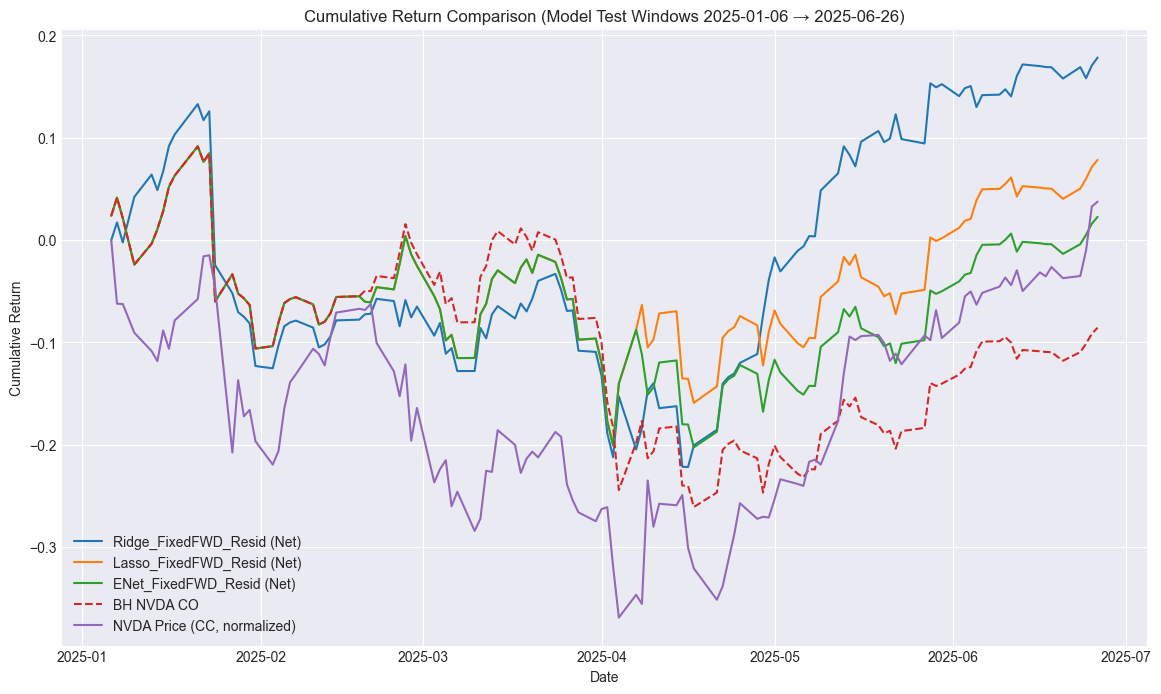

[INFO] Elastic Net hyperparameter plot saved to reports/ENet_FixedFWD_Resid_hyperparams_test_period.png


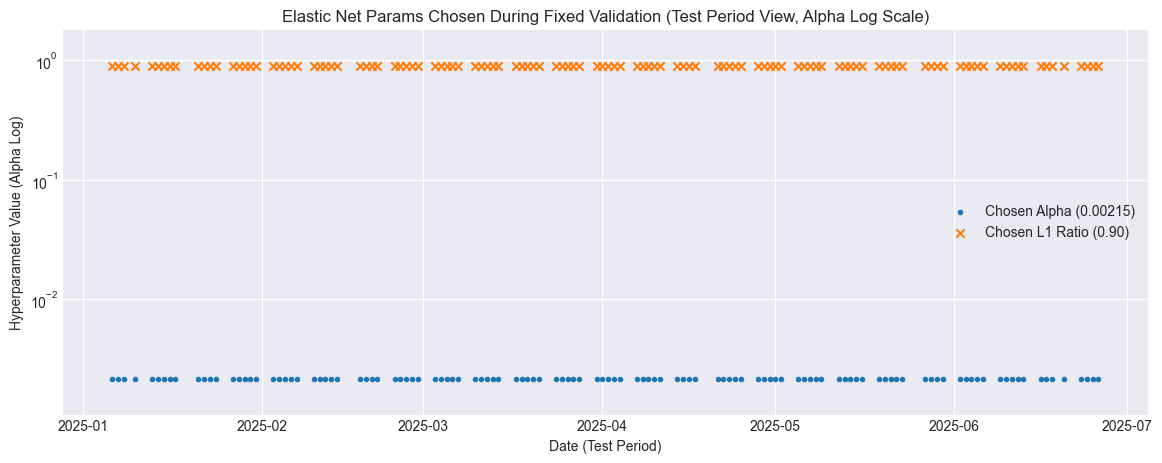

In [22]:
# Needed below
adj_close = data_cube["close"]

# Summarize results from the store
print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
# Assuming summarize_results function is defined in a previous cell
# It should already handle saving the summary to CSV.
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    # Display more precision in the summary table
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- Plotting Results ---
# Plot only models present in the results_store
if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0

    # Collect overall plotting window from model results
    all_min_dates = [df.index.min() for df in results_store.values() if df is not None and not df.empty]
    all_max_dates = [df.index.max() for df in results_store.values() if df is not None and not df.empty]
    start_dt = min(all_min_dates) if all_min_dates else None
    end_dt = max(all_max_dates) if all_max_dates else None

    # Plot strategy cumulative returns
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            # Add cumulative PnL column if needed
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1

            # Ensure data is available for plotting
            if not df["cum_pnl"].isna().all():
                # Align to (start_dt, end_dt) if available
                to_plot = df["cum_pnl"]
                if start_dt is not None and end_dt is not None:
                    to_plot = to_plot.loc[start_dt:end_dt]
                plt.plot(to_plot.index, to_plot.values, label=f"{name} (Net)")
                plot_count += 1
            else:
                print(f"[INFO] Skipping plot for {name} - cumulative PnL is all NaN.")

    # --- Add Buy & Hold NVDA Close-to-Open benchmark from a representative run (same window) ---
    bh_df_source = None
    bh_col_name = "cum_bh"
    for name, df in results_store.items():
        if df is not None and not df.empty and "y_real" in df.columns:
            bh_df_source = df[["y_real"]].copy()  # use this df's index & y_real
            break  # first valid one

    bh_added = False
    if bh_df_source is not None:
        # Restrict to the common plotting window
        if start_dt is not None and end_dt is not None:
            bh_df_source = bh_df_source.loc[start_dt:end_dt]
        if not bh_df_source.empty:
            bh_df_source[bh_col_name] = (1 + bh_df_source["y_real"].fillna(0)).cumprod() - 1
            if not bh_df_source[bh_col_name].isna().all():
                plt.plot(bh_df_source.index, bh_df_source[bh_col_name], label="BH NVDA CO", linestyle="--")
                bh_added = True
    else:
        print("[WARN] Could not plot Buy & Hold NVDA (CO) benchmark (no y_real found).")

    # --- Add NVDA share price movement (normalized CC price from start of plot) ---
    price_added = False
    try:
        if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and ("NVDA" in adj_close.columns):
            nvda_px = adj_close["NVDA"].dropna().sort_index()
            if start_dt is not None and end_dt is not None:
                nvda_px = nvda_px.loc[start_dt:end_dt]
            if len(nvda_px) >= 2:
                nvda_price_norm = (nvda_px / nvda_px.iloc[0]) - 1.0  # price_t / price_start - 1
                plt.plot(nvda_price_norm.index, nvda_price_norm.values, label="NVDA Price (CC, normalized)")
                price_added = True
        else:
            print("[WARN] 'adj_close' with NVDA column not found; cannot plot NVDA normalized price.")
    except Exception as e:
        print(f"[WARN] Failed to compute/plot NVDA normalized price: {e}")

    if plot_count > 0 or bh_added or price_added:
        # Title uses the overall model window
        if start_dt is not None and end_dt is not None:
            plt.title(f"Cumulative Return Comparison (Model Test Windows {start_dt.date()} → {end_dt.date()})")
        else:
            plt.title("Cumulative Return Comparison")

        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        # Save the plot
        try:
            plot_filename_cum = "cumulative_pnl_comparison_all_with_nvda_price.png"
            plt.savefig(RESULTS_DIR / plot_filename_cum)
            print(f"[INFO] Cumulative return plot saved to {RESULTS_DIR / plot_filename_cum}")
        except Exception as e:
            print(f"[ERROR] Failed to save cumulative return plot: {e}")
        plt.show()  # Display the plot
    else:
        print("[INFO] No valid model results or benchmarks to plot.")

    # --- Plot alpha and l1_ratio chosen over time for the ELASTIC NET model run (Fixed FWD) ---
    enet_model_key = "ENet_FixedFWD_Resid"  # Key used in register_results
    if enet_model_key in results_store:
        enet_df = results_store[enet_model_key]
        # Note: For fixed validation, 'hyperparam' column will have the SAME best (alpha, l1_ratio) tuple for all test rows.
        if "hyperparam" in enet_df.columns and not enet_df["hyperparam"].isna().all():
            plt.figure(figsize=(14, 5))

            # Extract the chosen alpha and l1_ratio (they are constant in this case)
            chosen_params = enet_df["hyperparam"].iloc[0]  # Get the tuple
            chosen_alpha = chosen_params[0]
            chosen_l1 = chosen_params[1]

            # Use scatter plot as values are constant for fixed validation test period
            # Plot alpha
            plt.scatter(
                enet_df.index,
                enet_df["hyperparam"].apply(lambda x: x[0]),
                marker=".",
                label=f"Chosen Alpha ({chosen_alpha:.5f})",
            )
            # Plot l1_ratio
            plt.scatter(
                enet_df.index,
                enet_df["hyperparam"].apply(lambda x: x[1]),
                marker="x",
                label=f"Chosen L1 Ratio ({chosen_l1:.2f})",
            )

            plt.yscale("log")  # Use log scale, mainly relevant for alpha
            plt.title("Elastic Net Params Chosen During Fixed Validation (Test Period View, Alpha Log Scale)")
            plt.xlabel("Date (Test Period)")
            plt.ylabel("Hyperparameter Value (Alpha Log)")

            # Adjust y-limits if needed for clarity
            min_val = min(chosen_alpha * 0.5, chosen_l1 * 0.5) if chosen_alpha > 0 and chosen_l1 > 0 else 0.00001
            max_val = max(chosen_alpha * 2, chosen_l1 * 2) if chosen_alpha > 0 and chosen_l1 > 0 else 10
            plt.ylim(min_val, max_val)

            plt.legend()
            plt.grid(True)
            # Save the plot
            try:
                plot_filename = f"{enet_model_key}_hyperparams_test_period.png"
                plt.savefig(RESULTS_DIR / plot_filename)
                print(f"[INFO] Elastic Net hyperparameter plot saved to {RESULTS_DIR / plot_filename}")
            except Exception as e:
                print(f"[ERROR] Failed to save hyperparameter plot for {enet_model_key}: {e}")
            plt.show()  # Display the plot
        else:
            print(f"[INFO] Hyperparameter column ('hyperparam') not available or empty for {enet_model_key}.")
    else:
        print(f"[INFO] Results for {enet_model_key} not found in results_store.")

else:
    print("[INFO] results_store is empty. Nothing to plot.")

In [23]:
# ============================
# Metrics Table for All Models
# ============================

# Config
PERIODS_PER_YEAR = 252
RET_COL = "pnl"  # per-period strategy return
SIG_COL = "signal"  # position column (optional; used if delta_pos missing)
DP_COL = "delta_pos"  # |signal - signal_prev| (optional)
INCLUDE_BH_CO_PER_MODEL = True  # add a BH NVDA CO row per model window if y_real is present


def _ann_return(r: pd.Series, periods=PERIODS_PER_YEAR):
    r = pd.Series(r).astype(float).dropna()
    if r.empty:
        return np.nan
    return r.mean() * periods


def _ann_vol(r: pd.Series, periods=PERIODS_PER_YEAR):
    r = pd.Series(r).astype(float).dropna()
    if len(r) <= 1:
        return np.nan
    return r.std(ddof=1) * np.sqrt(periods)


def _sharpe(r: pd.Series, periods=PERIODS_PER_YEAR):
    ar = _ann_return(r, periods)
    av = _ann_vol(r, periods)
    if av is None or (isinstance(av, float) and (np.isnan(av) or av == 0)):
        return np.nan
    return ar / av


def _max_drawdown(r: pd.Series):
    r = pd.Series(r).astype(float).dropna()
    if r.empty:
        return np.nan
    eq = (1 + r).cumprod()
    roll_max = eq.cummax()
    dd = eq / roll_max - 1.0
    return dd.min()


def _annualized_turnover(df: pd.DataFrame, sig_col=SIG_COL, dp_col=DP_COL, periods=PERIODS_PER_YEAR):
    """
    Turnover per day ~ average |delta position|; annualized by * periods.
    If 'delta_pos' exists, use it; else derive from 'signal'.
    """
    if dp_col in df.columns:
        dp = pd.Series(df[dp_col]).astype(float)
    elif sig_col in df.columns:
        sig = pd.Series(df[sig_col]).fillna(0)
        sig = sig.astype(float)  # ensure numeric
        dp = sig.diff().abs()
        if len(sig) > 0:
            # first day's change is entering from 0 exposure
            dp.iloc[0] = abs(sig.iloc[0])  # FIX: use built-in abs on scalar
    else:
        return np.nan

    dp = dp.replace([np.inf, -np.inf], np.nan).dropna()
    if dp.empty:
        return np.nan
    return dp.mean() * periods


def _compute_metrics_for_df(df: pd.DataFrame, label: str, ret_col=RET_COL) -> dict:
    if df is None or df.empty or ret_col not in df.columns:
        return {
            "Model": label,
            "Ann Return": np.nan,
            "Ann Vol": np.nan,
            "Sharpe": np.nan,
            "Max Drawdown": np.nan,
            "Ann Turnover": np.nan,
            "Start": pd.NaT,
            "End": pd.NaT,
            "N": 0,
        }
    r = pd.Series(df[ret_col]).astype(float)
    metrics = {
        "Model": label,
        "Ann Return": _ann_return(r),
        "Ann Vol": _ann_vol(r),
        "Sharpe": _sharpe(r),
        "Max Drawdown": _max_drawdown(r),
        "Ann Turnover": _annualized_turnover(df),
        "Start": r.dropna().index.min(),
        "End": r.dropna().index.max(),
        "N": r.dropna().shape[0],
    }
    return metrics


def _compute_bh_co_for_df(df: pd.DataFrame, label_suffix="BH NVDA CO (match window)") -> dict:
    if df is None or df.empty or "y_real" not in df.columns:
        return {
            "Model": label_suffix,
            "Ann Return": np.nan,
            "Ann Vol": np.nan,
            "Sharpe": np.nan,
            "Max Drawdown": np.nan,
            "Ann Turnover": 0.0,
            "Start": pd.NaT,
            "End": pd.NaT,
            "N": 0,
        }
    r = pd.Series(df["y_real"]).astype(float).dropna()
    metrics = {
        "Model": label_suffix,
        "Ann Return": _ann_return(r),
        "Ann Vol": _ann_vol(r),
        "Sharpe": _sharpe(r),
        "Max Drawdown": _max_drawdown(r),
        "Ann Turnover": 0.0,
        "Start": r.index.min(),
        "End": r.index.max(),
        "N": r.shape[0],
    }
    return metrics


# Build the table
rows = []
if results_store:
    for name, df in results_store.items():
        if df is None or df.empty:
            continue
        rows.append(_compute_metrics_for_df(df, label=name, ret_col=RET_COL))
        if INCLUDE_BH_CO_PER_MODEL:
            rows.append(_compute_bh_co_for_df(df, label_suffix=f"{name} - BH NVDA CO"))

metrics_df = pd.DataFrame(rows)
if not metrics_df.empty:
    cols_order = ["Model", "Ann Return", "Ann Vol", "Sharpe", "Max Drawdown", "Ann Turnover", "Start", "End", "N"]
    metrics_df = metrics_df[cols_order]
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print("\nMETRICS SUMMARY (Test Windows)")
        print(metrics_df.to_string(index=False))
    try:
        out_path = RESULTS_DIR / "metrics_summary.csv"
        metrics_df.to_csv(out_path, index=False)
        print(f"[INFO] Saved metrics table to {out_path}")
    except Exception as e:
        print(f"[WARN] Could not save metrics CSV: {e}")
else:
    print("[INFO] No metrics computed; 'results_store' empty or missing required columns.")


METRICS SUMMARY (Test Windows)
                            Model  Ann Return  Ann Vol  Sharpe  Max Drawdown  Ann Turnover      Start        End   N
             Ridge_FixedFWD_Resid      0.4397   0.4189  1.0496       -0.3130      198.6102 2025-01-06 2025-06-26 118
Ridge_FixedFWD_Resid - BH NVDA CO     -0.1006   0.4212 -0.2389       -0.3228        0.0000 2025-01-06 2025-06-26 118
             Lasso_FixedFWD_Resid      0.2511   0.4210  0.5965       -0.2676       53.3898 2025-01-06 2025-06-26 118
Lasso_FixedFWD_Resid - BH NVDA CO     -0.1006   0.4212 -0.2389       -0.3228        0.0000 2025-01-06 2025-06-26 118
              ENet_FixedFWD_Resid      0.1377   0.4212  0.3270       -0.2694       61.9322 2025-01-06 2025-06-26 118
 ENet_FixedFWD_Resid - BH NVDA CO     -0.1006   0.4212 -0.2389       -0.3228        0.0000 2025-01-06 2025-06-26 118
[INFO] Saved metrics table to reports/metrics_summary.csv


### Model 4: Non-linear Models

In [24]:
# =========================================
# Nonlinear Models: XGBoost and LightGBM
# Fixed forward validation (Train -> Val -> Test)
# =========================================
# Assumes the following exist from earlier cells:
# X_y, FEATURE_COLS, LABEL_COL, CTRL_COL, use_peers,
# TRAIN_OFFSET, VAL_OFFSET, TEST_OFFSET,
# calculate_betas, apply_resid_slice, register_results,
# RESULTS_DIR, ONE_WAY (0.0 per brief)

import numpy as np, pandas as pd
from itertools import product

# --- Safe imports (skip model if package missing) ---
try:
    import xgboost as xgb

    HAVE_XGB = True
except Exception as e:
    print(f"[WARN] XGBoost unavailable: {e}")
    HAVE_XGB = False

try:
    import lightgbm as lgb

    HAVE_LGBM = True
except Exception as e:
    print(f"[WARN] LightGBM unavailable: {e}")
    HAVE_LGBM = False

# --- 1) Define/reuse fixed splits ---
if "train_df_raw" not in locals() or "val_df_raw" not in locals() or "test_df_raw" not in locals():
    print("[INFO] Redefining fixed time splits for nonlinear models...")
    dates = X_y.index
    first_train_start = dates.min()
    train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
    val_end_date = train_end_date + VAL_OFFSET
    test_end_date = val_end_date + TEST_OFFSET

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

    print(
        f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} → {train_df_raw.index.max().date()} ({len(train_df_raw)})"
    )
    print(
        f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()}   → {val_df_raw.index.max().date()}   ({len(val_df_raw)})"
    )
    print(
        f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()}  → {test_df_raw.index.max().date()}  ({len(test_df_raw)})"
    )
else:
    print("[INFO] Using existing fixed splits.")

# --- 2) Residualize peers on TRAIN and apply to all splits ---
if "betas_fixed" not in locals():
    print("[INFO] Calculating residualization betas (TRAIN)...")
    betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, USE_PEERS)

X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_test_res = apply_resid_slice(test_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)

final_feature_cols = []
if CTRL_COL in FEATURE_COLS:
    final_feature_cols.append(CTRL_COL)
final_feature_cols += [p + "_res" for p in USE_PEERS]

# --- 3) Add NVDA style features (vol/mom/liquidity) ---
style_candidates = ["nvda_vol5", "nvda_mom1", "nvda_mom5", "nvda_log_dvol"]
style_cols = [c for c in style_candidates if c in FEATURE_COLS and c in train_df_raw.columns]

X_train_full = pd.concat([X_train_res[final_feature_cols], train_df_raw[style_cols]], axis=1)
X_val_full = pd.concat([X_val_res[final_feature_cols], val_df_raw[style_cols]], axis=1)
X_test_full = pd.concat([X_test_res[final_feature_cols], test_df_raw[style_cols]], axis=1)

y_train = train_df_raw[LABEL_COL]
y_val = val_df_raw[LABEL_COL]
y_test = test_df_raw[LABEL_COL]

# Drop NaNs coherently
train_fit_df = X_train_full.join(y_train.rename("y")).dropna()
val_fit_df = X_val_full.join(y_val.rename("y")).dropna()
test_fit_df = X_test_full.join(y_test.rename("y_real")).dropna()

if train_fit_df.empty or val_fit_df.empty:
    raise ValueError("[ERROR] Empty TRAIN or VAL after NaN drop for nonlinear models.")

Xtr, ytr = train_fit_df.drop(columns=["y"]), train_fit_df["y"]
Xva, yva = val_fit_df.drop(columns=["y"]), val_fit_df["y"]
Xte = test_fit_df.drop(columns=["y_real"])
yte = test_fit_df["y_real"]

# ===================================
# XGBoost (if available) — callback early stopping
# ===================================
if HAVE_XGB:
    print("\n" + "=" * 50)
    print("Executing XGBoost Backtest (Fixed Forward Validation)")
    print("=" * 50)

    xgb_grid = {
        "eta": [0.03, 0.06],
        "max_depth": [3, 4],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 1.0],
        "reg_lambda": [0.0, 1.0],
    }
    num_round = 800
    es_rounds = 50

    dtr = xgb.DMatrix(Xtr.values, label=ytr.values, feature_names=Xtr.columns.tolist())
    dva = xgb.DMatrix(Xva.values, label=yva.values, feature_names=Xva.columns.tolist())

    best_params, best_rmse, best_nrounds = None, np.inf, None
    for eta, md, ss, cs, rl in product(*xgb_grid.values()):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": eta,
            "max_depth": md,
            "subsample": ss,
            "colsample_bytree": cs,
            "reg_lambda": rl,
            "nthread": 4,
        }
        callbacks = [
            xgb.callback.EarlyStopping(
                rounds=es_rounds, save_best=True, maximize=False, data_name="val", metric_name="rmse"
            )
        ]
        booster = xgb.train(
            params,
            dtr,
            num_boost_round=num_round,
            evals=[(dtr, "train"), (dva, "val")],
            callbacks=callbacks,
            verbose_eval=False,
        )
        rmse = booster.best_score
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params.copy()
            best_nrounds = booster.best_iteration + 1

    print(f"[INFO] XGB best val RMSE={best_rmse:.6g} | best_nrounds={best_nrounds} | params={best_params}")

    # Refit on Train+Val with best params
    d_tv = xgb.DMatrix(
        pd.concat([Xtr, Xva]).values, label=pd.concat([ytr, yva]).values, feature_names=Xtr.columns.tolist()
    )
    booster_final = xgb.train(best_params, d_tv, num_boost_round=best_nrounds, verbose_eval=False)

    # Predict on Test
    dte = xgb.DMatrix(Xte.values, feature_names=Xtr.columns.tolist())
    y_hat = pd.Series(booster_final.predict(dte), index=Xte.index, name="y_hat")

    out_xgb = pd.DataFrame({"y_hat": y_hat}).join(yte.rename("y_real")).dropna()
    out_xgb["signal"] = np.where(out_xgb["y_hat"] > 0, 1, np.where(out_xgb["y_hat"] < 0, -1, 0))
    out_xgb["signal_prev"] = out_xgb["signal"].shift(1).fillna(0)
    legs = (out_xgb["signal"] - out_xgb["signal_prev"]).abs()
    out_xgb["cost"] = legs * ONE_WAY
    out_xgb["pnl"] = out_xgb["signal"] * out_xgb["y_real"] - out_xgb["cost"]
    out_xgb.index.name = "date"

    register_results("XGB_FixedFWD_ResidStyle", out_xgb)
else:
    print("[INFO] Skipping XGBoost block (package unavailable).")

# ===================================
# LightGBM (if available) — callback early stopping
# ===================================
if HAVE_LGBM:
    print("\n" + "=" * 50)
    print("Executing LightGBM Backtest (Fixed Forward Validation)")
    print("=" * 50)

    lgbm_grid = {
        "learning_rate": [0.03, 0.06],
        "num_leaves": [15, 31],
        "feature_fraction": [0.7, 1.0],
        "bagging_fraction": [0.7, 0.9],
        "lambda_l2": [0.0, 1.0],
        "min_data_in_leaf": [10, 25],
    }
    num_round = 1500
    es_rounds = 100

    ltr = lgb.Dataset(Xtr.values, label=ytr.values, feature_name=Xtr.columns.tolist(), free_raw_data=False)
    lva = lgb.Dataset(
        Xva.values, label=yva.values, feature_name=Xva.columns.tolist(), reference=ltr, free_raw_data=False
    )

    best_params_lgbm, best_rmse_lgbm, best_iter_lgbm = None, np.inf, None
    for lr, nl, ff, bf, l2, mdl in product(*lgbm_grid.values()):
        params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": lr,
            "num_leaves": nl,
            "feature_fraction": ff,
            "bagging_fraction": bf,
            "lambda_l2": l2,
            "min_data_in_leaf": mdl,
            "verbosity": -1,
            "num_threads": 4,
        }
        callbacks = [
            lgb.early_stopping(stopping_rounds=es_rounds, verbose=False),
            lgb.log_evaluation(period=0),  # silence
        ]
        gbm = lgb.train(
            params,
            ltr,
            num_boost_round=num_round,
            valid_sets=[ltr, lva],
            valid_names=["train", "val"],
            callbacks=callbacks,
        )
        # best_score structure depends on metric; here it's rmse
        rmse = gbm.best_score.get("val", {}).get("rmse", np.inf)
        if rmse < best_rmse_lgbm:
            best_rmse_lgbm = rmse
            best_params_lgbm = params.copy()
            best_iter_lgbm = gbm.best_iteration

    print(f"[INFO] LGBM best val RMSE={best_rmse_lgbm:.6g} | best_iter={best_iter_lgbm} | params={best_params_lgbm}")

    # Refit on Train+Val with best params
    l_tv = lgb.Dataset(
        pd.concat([Xtr, Xva]).values,
        label=pd.concat([ytr, yva]).values,
        feature_name=Xtr.columns.tolist(),
        free_raw_data=False,
    )
    gbm_final = lgb.train(
        best_params_lgbm, l_tv, num_boost_round=best_iter_lgbm, callbacks=[lgb.log_evaluation(period=0)]
    )

    # Predict on Test
    y_hat_lgbm = pd.Series(gbm_final.predict(Xte.values, num_iteration=best_iter_lgbm), index=Xte.index, name="y_hat")

    out_lgbm = pd.DataFrame({"y_hat": y_hat_lgbm}).join(yte.rename("y_real")).dropna()
    out_lgbm["signal"] = np.where(out_lgbm["y_hat"] > 0, 1, np.where(out_lgbm["y_hat"] < 0, -1, 0))
    out_lgbm["signal_prev"] = out_lgbm["signal"].shift(1).fillna(0)
    legs = (out_lgbm["signal"] - out_lgbm["signal_prev"]).abs()
    out_lgbm["cost"] = legs * ONE_WAY
    out_lgbm["pnl"] = out_lgbm["signal"] * out_lgbm["y_real"] - out_lgbm["cost"]
    out_lgbm.index.name = "date"

    register_results("LGBM_FixedFWD_ResidStyle", out_lgbm)
else:
    print("[INFO] Skipping LightGBM block (package unavailable).")

[INFO] Using existing fixed splits.

Executing XGBoost Backtest (Fixed Forward Validation)
[INFO] XGB best val RMSE=0.0219772 | best_nrounds=8 | params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.06, 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 0.0, 'nthread': 4}
[INFO] Results for XGB_FixedFWD_ResidStyle saved to reports/XGB_FixedFWD_ResidStyle_wf.csv

Executing LightGBM Backtest (Fixed Forward Validation)
[INFO] LGBM best val RMSE=0.0220411 | best_iter=1 | params={'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.03, 'num_leaves': 15, 'feature_fraction': 1.0, 'bagging_fraction': 0.7, 'lambda_l2': 1.0, 'min_data_in_leaf': 25, 'verbosity': -1, 'num_threads': 4}
[INFO] Results for LGBM_FixedFWD_ResidStyle saved to reports/LGBM_FixedFWD_ResidStyle_wf.csv



PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                          net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                        
Ridge_FixedFWD_Resid           0.4397       0.4189      1.0496     -0.1006   
Lasso_FixedFWD_Resid           0.2511       0.4210      0.5965     -0.1006   
ENet_FixedFWD_Resid            0.1377       0.4212      0.3270     -0.1006   
XGB_FixedFWD_ResidStyle       -0.0713       0.4212     -0.1693     -0.1006   
LGBM_FixedFWD_ResidStyle      -0.1006       0.4212     -0.2389     -0.1006   

                          bh_ann_vol  bh_sharpe  turnover_legs_per_day  \
model                                                                    
Ridge_FixedFWD_Resid          0.4212    -0.2389                 0.7881   
Lasso_FixedFWD_Resid          0.4212    -0.2389                 0.2119   
ENet_FixedFWD_Resid           0.4212    

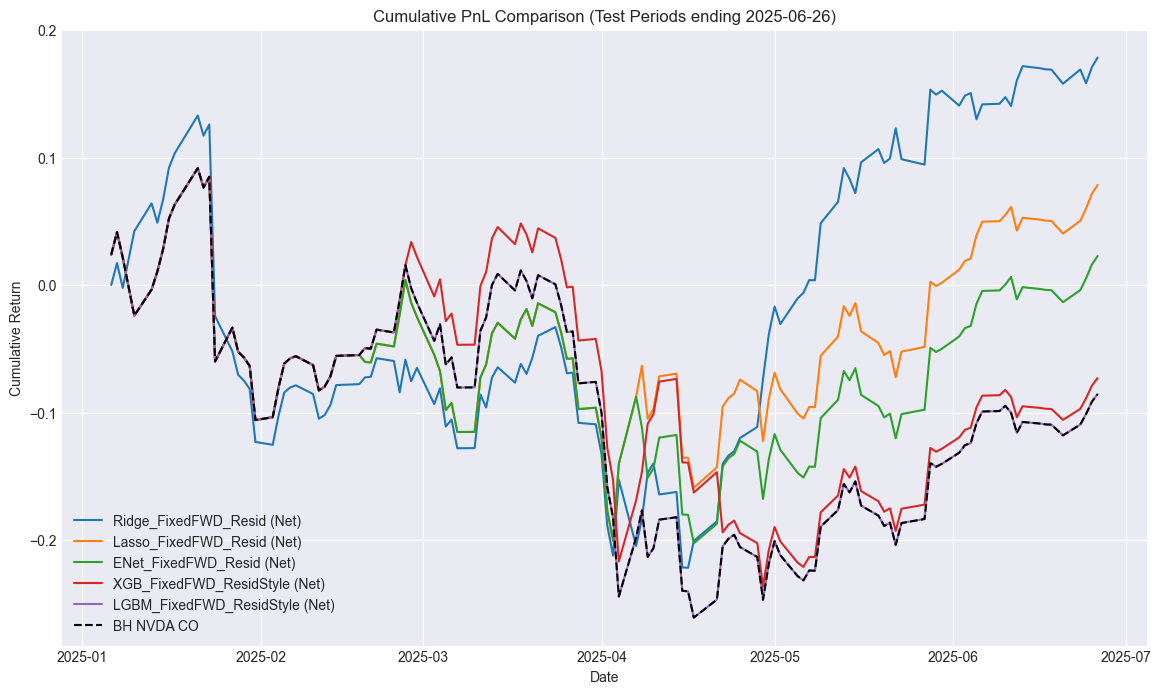

[INFO] XGB_FixedFWD_ResidStyle test rows: 118
[INFO] LGBM_FixedFWD_ResidStyle test rows: 118


In [25]:
# ============================
# Summary + Plots (All models)
# ============================
import matplotlib.pyplot as plt
import pandas as pd

print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

# --- Plotting Results ---
if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0

    # Plot strategy cumulative returns
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1
            curve = df["cum_pnl"].dropna()
            if not curve.empty:
                plt.plot(curve.index, curve.values, label=f"{name} (Net)")
                plot_count += 1

    # Add Buy & Hold NVDA Close-to-Open benchmark from a representative run
    bh_df_source = None
    for name, df in results_store.items():
        if df is not None and not df.empty and "y_real" in df.columns:
            bh_df_source = df[["y_real"]].copy()
            bh_df_source["cum_bh"] = (1 + bh_df_source["y_real"].fillna(0)).cumprod() - 1
            break
    if bh_df_source is not None and not bh_df_source["cum_bh"].isna().all():
        plt.plot(bh_df_source.index, bh_df_source["cum_bh"], label="BH NVDA CO", linestyle="--", color="black")
        plot_count += 1

    if plot_count > 0:
        all_min_dates = [df.index.min() for df in results_store.values() if df is not None and not df.empty]
        all_max_dates = [df.index.max() for df in results_store.values() if df is not None and not df.empty]
        if all_min_dates and all_max_dates:
            max_date_str = max(all_max_dates).date()
            plt.title(f"Cumulative PnL Comparison (Test Periods ending {max_date_str})")
        else:
            plt.title("Cumulative PnL Comparison")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        try:
            plot_filename_cum = "cumulative_pnl_comparison_all.png"
            plt.savefig(RESULTS_DIR / plot_filename_cum)
            print(f"[INFO] Cumulative PnL plot saved to {RESULTS_DIR / plot_filename_cum}")
        except Exception as e:
            print(f"[ERROR] Failed to save cumulative PnL plot: {e}")
        plt.show()
    else:
        print("[INFO] No valid model results found to plot.")

    # Optional: quick counts for the new models
    for key in ["XGB_FixedFWD_ResidStyle", "LGBM_FixedFWD_ResidStyle"]:
        if key in results_store and not results_store[key].empty:
            print(f"[INFO] {key} test rows: {len(results_store[key])}")
else:
    print("[INFO] results_store is empty. Nothing to plot.")

### Model 5: GARCH(1,1) Regression

In [26]:
# ================================
# ARX-GARCH with SIMPLE VALIDATION
# ================================
# Goal:
#   - Tune GARCH(p,q) (and optional AR mean lags m) by *simple forward validation*
#     using TRAIN -> VAL (minimize RMSE of mean forecast μ_t vs y_t).
#   - Refit the best spec on TRAIN+VAL.
#   - Evaluate on TEST with iterative 1-step-ahead forecasts.
#
# Assumptions / Requirements already defined upstream:
#   X_y, FEATURE_COLS, LABEL_COL, CTRL_COL, use_peers,
#   TRAIN_OFFSET, VAL_OFFSET, TEST_OFFSET,
#   calculate_betas, apply_resid_slice, register_results, ann_stats
#
# Notes:
#   - Per the brief, we report *gross* returns; costs are set to 0.0 below.
#   - Residualization uses fixed TRAIN betas, applied to VAL/TEST.
#   - Mean: ARX with m AR lags (can be 0), and exogenous residualized features.
#   - Variance: GARCH(p,q) with distribution 'normal' (configurable).
# =================================

from arch import arch_model
import numpy as np
import pandas as pd

# -----------------------------
# GARCH config & search grids
# -----------------------------
Z_TAU = 0.3  # trade only if |μ|/σ > Z_TAU; set None to always trade sign(μ)

# Hyperparameter grids for simple validation
P_GRID_GARCH = [1, 2]  # variance p
Q_GRID_GARCH = [1, 2]  # variance q
M_LAGS_GRID = [0, 1]  # mean AR lags m (0 = pure X regression)
DIST_OPTIONS = ["normal"]  # you can add: 't', 'ged' if desired

# Costs per the brief: set to zero
ONE_WAY = 0.0

# -----------------------------
# Fixed time splits (like ENet)
# -----------------------------
if "train_df_raw" not in locals() or "val_df_raw" not in locals() or "test_df_raw" not in locals():
    print("[INFO] Redefining fixed time splits for GARCH (simple validation)...")
    dates = X_y.index
    first_train_start = dates.min()
    train_end_date = first_train_start + TRAIN_OFFSET - pd.Timedelta(days=1)
    val_end_date = train_end_date + VAL_OFFSET
    test_end_date = val_end_date + TEST_OFFSET  # or use dates.max()

    train_df_raw = X_y.loc[first_train_start:train_end_date]
    val_df_raw = X_y.loc[train_end_date + pd.Timedelta(days=1) : val_end_date]
    test_df_raw = X_y.loc[val_end_date + pd.Timedelta(days=1) : test_end_date]

    print(
        f"[INFO] Fixed Splits | Train: {train_df_raw.index.min().date()} to {train_df_raw.index.max().date()} ({len(train_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Val  : {val_df_raw.index.min().date()}   to {val_df_raw.index.max().date()}   ({len(val_df_raw)} days)"
    )
    print(
        f"[INFO] Fixed Splits | Test : {test_df_raw.index.min().date()}  to {test_df_raw.index.max().date()}  ({len(test_df_raw)} days)"
    )

    if train_df_raw.empty or val_df_raw.empty or test_df_raw.empty:
        raise ValueError("One or more fixed data splits are empty. Check offsets and data availability.")
else:
    print("[INFO] Using existing fixed time splits.")

# -----------------------------
# Residualization betas (TRAIN)
# -----------------------------
if "betas_fixed" not in locals():
    print("[INFO] Calculating residualization betas on fixed TRAIN set for GARCH...")
    betas_fixed = calculate_betas(train_df_raw, FEATURE_COLS, CTRL_COL, USE_PEERS)
else:
    print("[INFO] Using existing fixed betas.")

# -----------------------------
# Apply residualization to splits
# -----------------------------
print("[INFO] Applying residualization to Train / Val / Test for GARCH...")
X_train_res = apply_resid_slice(train_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_val_res = apply_resid_slice(val_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)
X_test_res = apply_resid_slice(test_df_raw, betas_fixed, FEATURE_COLS, CTRL_COL, USE_PEERS)

# Final residualized feature names (consistent order)
final_feature_cols = []
if CTRL_COL in FEATURE_COLS:
    final_feature_cols.append(CTRL_COL)
final_feature_cols += [p + "_res" for p in USE_PEERS]
print(f"[INFO] Using residualized features: {final_feature_cols}")

# add NVDA style features (vol/mom/liquidity) into the ARX design
style_candidates = ["nvda_vol5", "nvda_mom1", "nvda_mom5", "nvda_log_dvol"]
style_cols = [c for c in style_candidates if c in FEATURE_COLS and c in train_df_raw]

# build FULL design = residualized peers (+ctrl) ⨁ style features
X_train_full = pd.concat([X_train_res[final_feature_cols], train_df_raw[style_cols]], axis=1)
X_val_full = pd.concat([X_val_res[final_feature_cols], val_df_raw[style_cols]], axis=1)
X_test_full = pd.concat([X_test_res[final_feature_cols], test_df_raw[style_cols]], axis=1)

# Targets
y_train = train_df_raw[LABEL_COL].astype(float)
y_val = val_df_raw[LABEL_COL].astype(float)
y_test = test_df_raw[LABEL_COL].astype(float)

# standardize exogenous features with TRAIN stats; apply to VAL/TEST (no leakage)
mu_train = X_train_full.mean()
sd_train = X_train_full.std(ddof=1).replace(0, np.nan)
X_train_full = (X_train_full - mu_train) / sd_train
X_val_full = (X_val_full - mu_train) / sd_train
X_test_full = (X_test_full - mu_train) / sd_train

# Keep the column order consistent for arch_model (x0, x1, ...)
full_feature_cols = X_train_full.columns.tolist()


# -----------------------------
# Helper: 1-step variance update
# -----------------------------
def manual_garch11_next_var_from_params(omega, alpha1, beta1, last_resid: float, last_sigma: float):
    """Compute σ²_{t+1} = ω + α * ε_t² + β * σ_t² (non-negative)."""
    return max(float(omega) + float(alpha1) * (last_resid**2) + float(beta1) * (last_sigma**2), 0.0)


# -----------------------------
# Helper: extract mean/var params
# -----------------------------
def _extract_params(result):
    """
    Extracts:
      - mean: const & x-coefs x0,x1,... and AR lags (ar.L1, ar.L2, ...)
      - var:  omega, alpha[1], beta[1] (for p=q=1); for larger p,q, fall back to sums
    Returns dict with keys:
      'Const', 'x_coefs' (list), 'ar_coefs' (list), 'omega', 'alpha1', 'beta1'
    """
    params = result.params
    # Mean params
    const = float(params.get("Const", 0.0))
    # x0, x1, ...
    x_coefs = []
    j = 0
    while f"x{j}" in params.index:
        x_coefs.append(float(params[f"x{j}"]))
        j += 1
    # AR lags: arch labels like 'ar.L1', 'ar.L2', ...
    ar_coefs = []
    k = 1
    while f"ar.L{k}" in params.index:
        ar_coefs.append(float(params[f"ar.L{k}"]))
        k += 1

    # Var params: try to map general p,q to alpha1,beta1 via first terms or sums
    omega = float(params.get("omega", 0.0))
    # alpha terms alpha[1], alpha[2], ...
    alpha1 = 0.0
    l = 1
    alphas = []
    while f"alpha[{l}]" in params.index:
        alphas.append(float(params[f"alpha[{l}]"]))
        l += 1
    # beta terms beta[1], beta[2], ...
    beta1 = 0.0
    m = 1
    betas = []
    while f"beta[{m}]" in params.index:
        betas.append(float(params[f"beta[{m}]"]))
        m += 1

    if len(alphas) > 0:
        alpha1 = alphas[0]  # use first term
    if len(betas) > 0:
        beta1 = betas[0]  # use first term
    # If you prefer sum of terms for the recursion strength, swap to sum(alphas), sum(betas)

    return {"Const": const, "x_coefs": x_coefs, "ar_coefs": ar_coefs, "omega": omega, "alpha1": alpha1, "beta1": beta1}


# -----------------------------
# Helper: iterative 1-step mean/vol forecast given fixed params
# -----------------------------
def _iterative_forecast_block(
    y_block: pd.Series,
    X_block: pd.DataFrame,
    params_dict: dict,
    init_resid: float,
    init_sigma: float,
    z_tau: float | None = Z_TAU,
):
    """
    Iteratively produce 1-step-ahead forecasts (μ_t, σ_t) over the given block (index order).
    y_block: actual returns (used only for residual updates & scoring)
    X_block: exogenous design with columns [x0..xJ-1]; must match the order of params_dict['x_coefs'] length.
    params_dict: output of _extract_params
    init_resid, init_sigma: last residual & sigma from the previous fit period (end of Train or Train+Val)
    Returns DataFrame with columns: ['mu_hat', 'sigma_hat', 'z_score', 'y_real', 'signal', 'pnl']
    """
    out_rows = []
    last_resid = float(init_resid)
    last_sigma = float(init_sigma)

    # Build AR mean history buffer for AR lags on μ (if any)
    ar_coefs = params_dict["ar_coefs"]
    ar_order = len(ar_coefs)
    # We'll store past realized y to feed AR terms; if not enough history, use zeros
    y_hist = []

    for t, xt in X_block.iterrows():
        # Ensure exog vector length matches
        xvals = xt.values.astype(float)
        # mean forecast μ_t = Const + x·β + sum_{k=1..m} φ_k * y_{t-k}
        mu_hat = (
            params_dict["Const"] + float(np.dot(params_dict["x_coefs"], xvals))
            if params_dict["x_coefs"]
            else params_dict["Const"]
        )
        if ar_order > 0:
            # Add AR terms; use available y_hist (latest first)
            for k in range(1, ar_order + 1):
                y_lag = y_hist[-k] if len(y_hist) >= k else 0.0
                mu_hat += params_dict["ar_coefs"][k - 1] * y_lag

        # variance forecast from last step's residual & sigma
        var_hat = manual_garch11_next_var_from_params(
            params_dict["omega"], params_dict["alpha1"], params_dict["beta1"], last_resid, last_sigma
        )
        sigma_hat = float(np.sqrt(var_hat)) if var_hat >= 0 else np.nan

        y_real = float(y_block.loc[t]) if t in y_block.index else np.nan

        # Trading signal from μ and σ
        if (z_tau is not None) and (sigma_hat is not None) and (sigma_hat > 1e-9) and (not np.isnan(mu_hat)):
            z = mu_hat / sigma_hat
            sig = 1 if z > z_tau else (-1 if z < -z_tau else 0)
            z_score = z
        elif not np.isnan(mu_hat):
            sig = 1 if mu_hat > 0 else (-1 if mu_hat < 0 else 0)
            z_score = np.nan
        else:
            sig = 0
            z_score = np.nan

        # Gross PnL (no costs per brief)
        pnl = sig * y_real if not np.isnan(y_real) else 0.0

        out_rows.append(
            {
                "date": t,
                "mu_hat": mu_hat,
                "sigma_hat": sigma_hat,
                "z_score": z_score,
                "y_real": y_real,
                "signal": sig,
                "pnl": pnl,
            }
        )

        # Update recursion with *realized* y and current μ
        if not np.isnan(y_real) and not np.isnan(mu_hat):
            last_resid = y_real - mu_hat
        # Carry forward sigma for next step
        if not np.isnan(sigma_hat):
            last_sigma = sigma_hat

        # Update AR buffer
        if not np.isnan(y_real):
            y_hist.append(y_real)

    df_out = pd.DataFrame.from_records(out_rows).set_index("date").sort_index()
    # signal_prev & delta_pos (for optional turnover metric)
    if not df_out.empty:
        df_out["signal_prev"] = df_out["signal"].shift(1).fillna(0)
        df_out["delta_pos"] = (df_out["signal"] - df_out["signal_prev"]).abs()
    return df_out


# -----------------------------
# SIMPLE VALIDATION: tune (p,q,m,dist) on TRAIN -> VAL
# -----------------------------
print("\n[INFO] Tuning ARX-GARCH hyperparameters by simple validation (RMSE on μ vs y)...")
best_spec = None
best_rmse = np.inf
best_fit_train = None
best_end_resid = None
best_end_sigma = None
best_features_used = None

# Build TRAIN design
Xtr_full = X_train_full.copy()
ytr_full = y_train.copy()
# Build VAL design
Xva_full = X_val_full.copy()
yva_full = y_val.copy()

# Drop NaNs coherently
tr_df = Xtr_full.join(ytr_full.rename("y")).dropna()
va_df = Xva_full.join(yva_full.rename("y")).dropna()

if tr_df.empty or va_df.empty:
    raise ValueError("[ERROR] TRAIN or VAL is empty after residualization/NaN drop.")

Xtr = tr_df[full_feature_cols].astype(float).values
ytr = tr_df["y"].astype(float).values
Xva = va_df[full_feature_cols].astype(float)  # keep as DataFrame for iterative loop
yva = va_df["y"].astype(float)

for dist in DIST_OPTIONS:
    for m in M_LAGS_GRID:
        for p in P_GRID_GARCH:
            for q in Q_GRID_GARCH:
                # Fit on TRAIN
                try:
                    am = arch_model(ytr, mean="ARX", lags=m, x=Xtr, vol="GARCH", p=p, q=q, dist=dist, rescale=False)
                    res_tr = am.fit(disp="off")
                except Exception as e:
                    print(f"[WARN] TRAIN fit failed for (p={p}, q={q}, m={m}, dist={dist}): {e}")
                    continue

                # Extract params and last state
                params_d = _extract_params(res_tr)
                last_resid_tr = float(res_tr.resid[-1])
                last_sigma_tr = float(res_tr.conditional_volatility[-1])

                # Build the same feature order for VAL as Xtr used ('x0','x1',...)
                Xva_ordered = Xva[full_feature_cols].copy()

                # Iterative 1-step forecasts across VAL
                df_val_fore = _iterative_forecast_block(
                    y_block=yva,
                    X_block=Xva_ordered,
                    params_dict=params_d,
                    init_resid=last_resid_tr,
                    init_sigma=last_sigma_tr,
                    z_tau=None,  # DO NOT gate by z in validation; we score μ vs y
                )

                # RMSE of mean forecast on VAL
                valid = df_val_fore[["mu_hat"]].join(yva.rename("y_real")).dropna()
                if valid.empty:
                    rmse = np.inf
                else:
                    err = valid["y_real"] - valid["mu_hat"]
                    rmse = float(np.sqrt((err**2).mean()))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_spec = {"p": p, "q": q, "m": m, "dist": dist}
                    best_fit_train = res_tr
                    best_end_resid = last_resid_tr
                    best_end_sigma = last_sigma_tr
                    best_features_used = full_feature_cols.copy()

print(f"[INFO] Best spec by VAL RMSE: {best_spec} | RMSE={best_rmse:.6e}")

# -----------------------------
# Final fit on TRAIN+VAL (best spec)
# -----------------------------
print("[INFO] Fitting final ARX-GARCH on TRAIN+VAL with best spec...")
X_tv_res = pd.concat([X_train_full, X_val_full], axis=0)[full_feature_cols]
y_tv = pd.concat([y_train, y_val], axis=0)

fit_df = X_tv_res.join(y_tv.rename("y")).dropna()
if fit_df.empty or (best_spec is None):
    print("[ERROR] Not enough data or no best spec; cannot fit final model.")
    final_garch_fit = None
else:
    Xtv = fit_df[full_feature_cols].astype(float).values
    ytv = fit_df["y"].astype(float).values
    try:
        am_final = arch_model(
            ytv,
            mean="ARX",
            lags=best_spec["m"],
            x=Xtv,
            vol="GARCH",
            p=best_spec["p"],
            q=best_spec["q"],
            dist=best_spec["dist"],
            rescale=False,
        )
        final_garch_fit = am_final.fit(disp="off")
        print("[INFO] Final ARX-GARCH model fitted.")
    except Exception as e:
        print(f"[ERROR] Final ARX-GARCH fit failed: {e}")
        final_garch_fit = None

# -----------------------------
# Test: iterative forecast over TEST (signals & pnl)
# -----------------------------
test_records_garch = []
prev_sig_garch = 0

if (final_garch_fit is not None) and (not X_test_full.empty):
    print("[INFO] Evaluating final ARX-GARCH on TEST (iterative 1-step forecasts)...")

    # Extract params from final fit
    params_final = _extract_params(final_garch_fit)
    # Initial state from end of TRAIN+VAL
    last_resid_fit = float(final_garch_fit.resid[-1])
    last_sigma_fit = float(final_garch_fit.conditional_volatility[-1])

    # Prepare TEST design (same feature order)
    X_test_predict = X_test_full[full_feature_cols].astype(float).copy()

    # Iterative forecasts across the TEST index
    df_test_fore = _iterative_forecast_block(
        y_block=y_test.astype(float),
        X_block=X_test_predict,
        params_dict=params_final,
        init_resid=last_resid_fit,
        init_sigma=last_sigma_fit,
        z_tau=Z_TAU,  # apply trading gate on TEST
    )

    # Add previous signal and cost (cost=0)
    if not df_test_fore.empty:
        df_test_fore["signal_prev"] = df_test_fore["signal"].shift(1).fillna(0)
        df_test_fore["cost"] = 0.0  # no transaction costs per brief
        df_test_fore["pnl"] = df_test_fore["signal"] * df_test_fore["y_real"]  # gross

    # Attach meta / hyperparam
    df_test_fore["hyperparam"] = (
        f"GARCH(p={best_spec['p']}, q={best_spec['q']}), AR lags={best_spec['m']}, dist={best_spec['dist']}"
    )

    wf_garch_fixed_res = df_test_fore.copy()
    wf_garch_fixed_res.index.name = "date"
else:
    print("[WARN] Final GARCH model not trained or TEST set empty. Skipping evaluation.")
    wf_garch_fixed_res = pd.DataFrame()

# -----------------------------
# Register results
# -----------------------------
garch_model_name = "ARXGARCH_FixedFWD_Resid"  # indicates fixed forward validation
register_results(garch_model_name, wf_garch_fixed_res)

# Optional peek
if not wf_garch_fixed_res.empty:
    print(f"\n[INFO] {garch_model_name} (head):")
    print(wf_garch_fixed_res.head())
else:
    print(f"[INFO] No results generated for {garch_model_name}.")
print("=" * 50)

[INFO] Using existing fixed time splits.
[INFO] Using existing fixed betas.
[INFO] Applying residualization to Train / Val / Test for GARCH...
[INFO] Using residualized features: ['SOXX_log_return', 'AAPL_log_return_res', 'ADBE_log_return_res', 'AKAM_log_return_res', 'AMAT_log_return_res', 'AMD_log_return_res', 'AMZN_log_return_res', 'ANET_log_return_res', 'ASML_log_return_res', 'AVGO_log_return_res', 'CAT_log_return_res', 'CRM_log_return_res', 'CSCO_log_return_res', 'DASTY_log_return_res', 'DELL_log_return_res', 'GOOGL_log_return_res', 'HNHPF_log_return_res', 'HPE_log_return_res', 'ILMN_log_return_res', 'INTC_log_return_res', 'IQV_log_return_res', 'JNJ_log_return_res', 'KLAC_log_return_res', 'LCID_log_return_res', 'LI_log_return_res', 'LLY_log_return_res', 'LNVGY_log_return_res', 'LOW_log_return_res', 'LRCX_log_return_res', 'MBGYY_log_return_res', 'META_log_return_res', 'MSFT_log_return_res', 'MU_log_return_res', 'NIO_log_return_res', 'NOK_log_return_res', 'NOW_log_return_res', 'NVDA_


PERFORMANCE SUMMARY (All Models)
[INFO] Model summary saved to reports/model_summary.csv

Summary Statistics Table:
                          net_ann_ret  net_ann_vol  net_sharpe  bh_ann_ret  \
model                                                                        
ARXGARCH_FixedFWD_Resid        0.8359       0.3272      2.5549     -0.1006   
Ridge_FixedFWD_Resid           0.4397       0.4189      1.0496     -0.1006   
Lasso_FixedFWD_Resid           0.2511       0.4210      0.5965     -0.1006   
ENet_FixedFWD_Resid            0.1377       0.4212      0.3270     -0.1006   
XGB_FixedFWD_ResidStyle       -0.0713       0.4212     -0.1693     -0.1006   
LGBM_FixedFWD_ResidStyle      -0.1006       0.4212     -0.2389     -0.1006   

                          bh_ann_vol  bh_sharpe  turnover_legs_per_day  \
model                                                                    
ARXGARCH_FixedFWD_Resid       0.4212    -0.2389                 0.7627   
Ridge_FixedFWD_Resid          0.4212

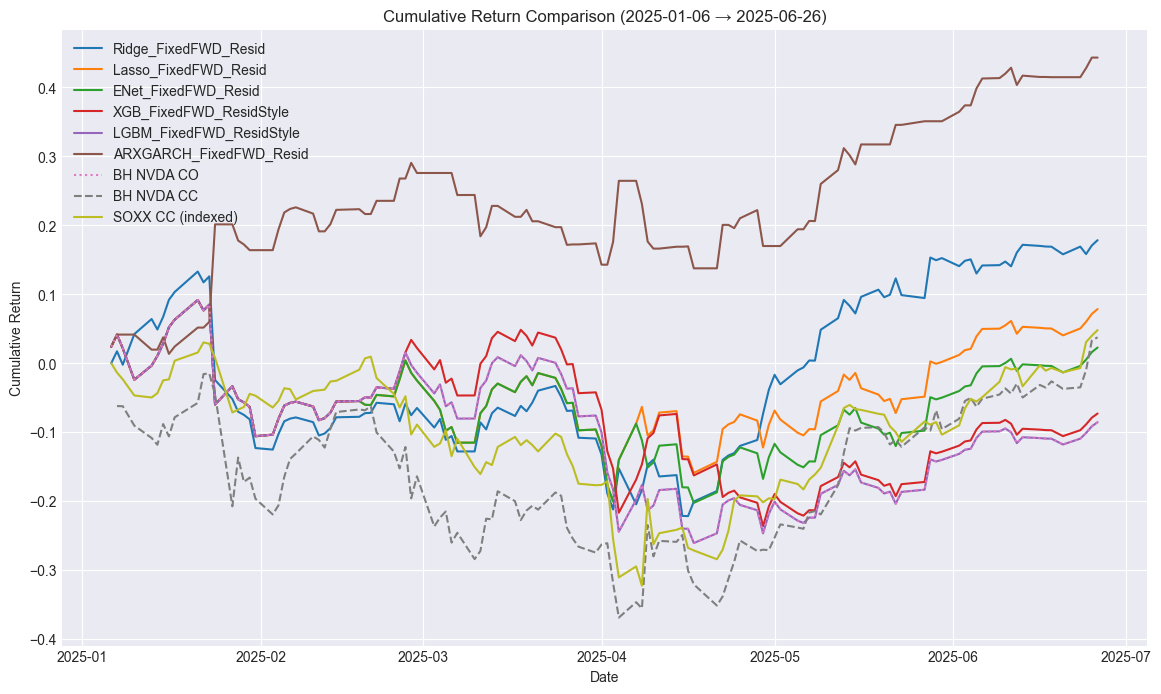

In [27]:
# ================================
# PLOTS (no duplicate benchmarks)
# ================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt

print("\n" + "=" * 40)
print("PERFORMANCE SUMMARY (All Models)")
print("=" * 40)
results_summary = summarize_results(results_store)
if results_summary is not None and not results_summary.empty:
    print("\nSummary Statistics Table:")
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print(results_summary)
else:
    print("No model results available to summarize.")
print("=" * 40)

if results_store:
    plt.figure(figsize=(14, 8))
    plot_count = 0

    # 1) Plot all strategy curves
    ret_windows = []
    for name, df in results_store.items():
        if df is not None and not df.empty and "pnl" in df.columns:
            if "cum_pnl" not in df.columns:
                df["cum_pnl"] = (1 + df["pnl"].fillna(0)).cumprod() - 1
            curve = df["cum_pnl"].dropna()
            if not curve.empty:
                plt.plot(curve.index, curve.values, label=f"{name}")
                plot_count += 1
                ret_windows.append((curve.index.min(), curve.index.max()))

    if plot_count == 0:
        print("[INFO] No strategy returns to plot.")
        plt.close()
    else:
        # 2) Build a COMMON window (intersection) for benchmarks
        #    start = latest of all starts; end = earliest of all ends
        common_start = max(s for s, _ in ret_windows)
        common_end = min(e for _, e in ret_windows)
        if common_start >= common_end:
            print("[WARN] No overlapping window across models; benchmarks skipped.")
        else:
            # --- BH NVDA CO (from any CO-model's y_real), once
            co_series = None
            for name, df in results_store.items():
                if df is not None and not df.empty and "y_real" in df.columns:
                    s = df["y_real"].dropna()
                    s = s.loc[(s.index >= common_start) & (s.index <= common_end)]
                    if len(s) > 0:
                        co_series = s
                        break
            if co_series is not None and len(co_series) > 0:
                bh_co = (1 + co_series).cumprod() - 1
                plt.plot(bh_co.index, bh_co.values, linestyle=":", label="BH NVDA CO")

            # --- BH NVDA CC (from adj_close), once
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "NVDA" in adj_close.columns:
                px = adj_close["NVDA"].dropna().sort_index()
                px = px.loc[(px.index >= common_start) & (px.index <= common_end)]
                if len(px) >= 2:
                    bh_cc = (1 + px.pct_change().dropna()).cumprod() - 1
                    plt.plot(bh_cc.index, bh_cc.values, linestyle="--", label="BH NVDA CC")

            # --- SOXX (indexed), once
            if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "SOXX" in adj_close.columns:
                soxx = adj_close["SOXX"].dropna().sort_index()
                soxx = soxx.loc[(soxx.index >= common_start) & (soxx.index <= common_end)]
                if len(soxx) >= 2:
                    soxx_norm = (soxx / soxx.iloc[0]) - 1.0
                    plt.plot(soxx_norm.index, soxx_norm.values, label="SOXX CC (indexed)")

        # 3) Finish
        plt.title(f"Cumulative Return Comparison ({common_start.date()} → {common_end.date()})")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        try:
            out = RESULTS_DIR / "cumulative_pnl_comparison_no_dupe_benchmarks.png"
            plt.savefig(out)
            print(f"[INFO] Plot saved to {out}")
        except Exception as e:
            print(f"[ERROR] Saving plot failed: {e}")
        plt.show()
else:
    print("[INFO] results_store is empty. Nothing to plot.")

In [28]:
# ===========================================
# METRICS TABLE (single BH NVDA CO/CC & SOXX)
# ===========================================
import numpy as np, pandas as pd

PERIODS_PER_YEAR = 252
RET_COL, SIG_COL, DP_COL = "pnl", "signal", "delta_pos"


def _ann_return(r):
    r = r.dropna()
    return np.nan if r.empty else r.mean() * PERIODS_PER_YEAR


def _ann_vol(r):
    r = r.dropna()
    return np.nan if len(r) <= 1 else r.std(ddof=1) * np.sqrt(PERIODS_PER_YEAR)


def _sharpe(r):
    ar, av = _ann_return(r), _ann_vol(r)
    return np.nan if (av is np.nan or not av or np.isnan(av)) else ar / av


def _mdd(r):
    r = r.dropna()
    if r.empty:
        return np.nan
    eq = (1 + r).cumprod()
    return (eq / eq.cummax() - 1).min()


def _turnover(df):
    if DP_COL in df.columns:
        dp = pd.Series(df[DP_COL]).astype(float)
    elif SIG_COL in df.columns:
        sig = pd.Series(df[SIG_COL]).fillna(0).astype(float)
        dp = sig.diff().abs()
        if len(sig) > 0:
            dp.iloc[0] = abs(sig.iloc[0])
    else:
        return np.nan
    dp = dp.replace([np.inf, -np.inf], np.nan).dropna()
    return np.nan if dp.empty else dp.mean() * PERIODS_PER_YEAR


def _metrics_row(label, r):
    r = pd.Series(r).astype(float).dropna()
    if r.empty:
        return {
            "Model": label,
            "Ann Return": np.nan,
            "Ann Vol": np.nan,
            "Sharpe": np.nan,
            "Max Drawdown": np.nan,
            "Ann Turnover": 0.0,
            "Start": pd.NaT,
            "End": pd.NaT,
            "N": 0,
        }
    return {
        "Model": label,
        "Ann Return": _ann_return(r),
        "Ann Vol": _ann_vol(r),
        "Sharpe": _sharpe(r),
        "Max Drawdown": _mdd(r),
        "Ann Turnover": 0.0,
        "Start": r.index.min(),
        "End": r.index.max(),
        "N": r.shape[0],
    }


rows = []

# 1) Strategy rows + build common window (intersection) for unified benchmarks
windows = []
if results_store:
    for name, df in results_store.items():
        if df is None or df.empty or RET_COL not in df.columns:
            continue
        r = pd.Series(df[RET_COL]).astype(float).dropna()
        if r.empty:
            continue
        rows.append(
            {
                "Model": name,
                "Ann Return": _ann_return(r),
                "Ann Vol": _ann_vol(r),
                "Sharpe": _sharpe(r),
                "Max Drawdown": _mdd(r),
                "Ann Turnover": _turnover(df),
                "Start": r.index.min(),
                "End": r.index.max(),
                "N": r.shape[0],
            }
        )
        windows.append((r.index.min(), r.index.max()))

# 2) Unified benchmarks ONCE using the common (intersection) window
if windows:
    common_start = max(s for s, _ in windows)
    common_end = min(e for _, e in windows)
    if common_start < common_end:
        # BH NVDA CO from any y_real series
        co_series = None
        for _, df in results_store.items():
            if df is not None and not df.empty and "y_real" in df.columns:
                s = df["y_real"].dropna()
                s = s.loc[(s.index >= common_start) & (s.index <= common_end)]
                if len(s) > 0:
                    co_series = s
                    break
        if co_series is not None:
            rows.append(_metrics_row("BH NVDA CO", co_series))

        # BH NVDA CC from adj_close
        if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "NVDA" in adj_close.columns:
            px = adj_close["NVDA"].dropna().sort_index().loc[common_start:common_end]
            if len(px) >= 2:
                r_cc = px.pct_change().dropna()
                rows.append(_metrics_row("BH NVDA CC", r_cc))

        # SOXX CC from adj_close
        if "adj_close" in locals() and isinstance(adj_close, pd.DataFrame) and "SOXX" in adj_close.columns:
            soxx_px = adj_close["SOXX"].dropna().sort_index().loc[common_start:common_end]
            if len(soxx_px) >= 2:
                soxx_r = soxx_px.pct_change().dropna()
                rows.append(_metrics_row("SOXX CC", soxx_r))
    else:
        print("[WARN] No overlapping window across models; unified benchmarks omitted.")

metrics_df = pd.DataFrame(rows)
if not metrics_df.empty:
    cols = ["Model", "Ann Return", "Ann Vol", "Sharpe", "Max Drawdown", "Ann Turnover", "Start", "End", "N"]
    metrics_df = metrics_df[cols]
    with pd.option_context("display.float_format", "{:,.4f}".format):
        print("\nMETRICS SUMMARY (Common Window)")
        print(metrics_df.to_string(index=False))
    try:
        out_path = RESULTS_DIR / "metrics_summary_no_dupes.csv"
        metrics_df.to_csv(out_path, index=False)
        print(f"[INFO] Saved metrics table to {out_path}")
    except Exception as e:
        print(f"[WARN] Could not save metrics CSV: {e}")
else:
    print("[INFO] No metrics computed; check results_store.")


METRICS SUMMARY (Common Window)
                   Model  Ann Return  Ann Vol  Sharpe  Max Drawdown  Ann Turnover      Start        End   N
    Ridge_FixedFWD_Resid      0.4397   0.4189  1.0496       -0.3130      198.6102 2025-01-06 2025-06-26 118
    Lasso_FixedFWD_Resid      0.2511   0.4210  0.5965       -0.2676       53.3898 2025-01-06 2025-06-26 118
     ENet_FixedFWD_Resid      0.1377   0.4212  0.3270       -0.2694       61.9322 2025-01-06 2025-06-26 118
 XGB_FixedFWD_ResidStyle     -0.0713   0.4212 -0.1693       -0.3005       27.7627 2025-01-06 2025-06-26 118
LGBM_FixedFWD_ResidStyle     -0.1006   0.4212 -0.2389       -0.3228        2.1356 2025-01-06 2025-06-26 118
 ARXGARCH_FixedFWD_Resid      0.8359   0.3272  2.5549       -0.1185      192.2034 2025-01-06 2025-06-26 118
              BH NVDA CO     -0.1006   0.4212 -0.2389       -0.3228        0.0000 2025-01-06 2025-06-26 118
              BH NVDA CC      0.2808   0.6353  0.4419       -0.3593        0.0000 2025-01-07 2025-06-26